<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_11/blob/main/goit_python_ds_hw_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 11. Рекурентні нейронні мережі. Tensorflow. Keras.

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras import layers, models, callbacks
from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model
from keras.utils import serialize_keras_object, to_categorical

import numpy as np

from matplotlib.ticker import MultipleLocator, AutoLocator, FixedLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score


# LOAD DATASET

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

In [3]:
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
words_index=imdb.get_word_index()
words = { v: k for k, v in words_index.items()}

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
x_train = pad_sequences(input_train, maxlen=maxlen)
x_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів


In [5]:
print(x_train.shape)
print(x_train[0])
n = 0
for i in x_train[0]:
  if i < 3:
    continue
  print(i, words.get(i-3))
  n += 1
  if n > 10:
    break

(25000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [6]:
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
learning_rate = 0.001 # швидкість навчання нейронної мережі
ignore_saved_model = False
upload_saved_model = True
every_model_zip = True
use_test_for_validate = False
model_zip_url = ""
model_zip = Path("goit_python_ds_hw_11_models.zip")
gdrive = Path("/content/drive/")
model_zip_gdrive_dir = gdrive.joinpath("MyDrive/Colab Notebooks/GoIT/datasets/")
model_zip_gdrive = model_zip_gdrive_dir.joinpath(model_zip)
tensorboard_path = "tensorboard"
tensorboard_logs = "logs"

In [7]:
models_dnn = {}
models_his = {}
results = {}

validation_split = 0.0
validation_data = None

if use_test_for_validate:
  validation_data = (x_test, y_test)
else:
  validation_split = 0.3

In [8]:
# @title
from logging import exception
# LOAD, SAVE MODLELS AND HISTORY

def load_models_gdrive(model_zip):
  print(model_zip)
  if model_zip.exists():
      print("Uzipping...")
      !unzip -q -o "$model_zip"


def load_models_url(zip_url, model_zip):
 if not model_zip.exists():
    !wget $zip_url -O $model_zip
    if model_zip.exists():
      !unzip -o $model_zip


def save_all():
  for name in models_dnn:
    print(f"Save {name}")
    savemodel(name, models_dnn[name], models_his[name])
  zip_files()


def zip_files(name=None):
  print(f"Creating {model_zip}")
  model_zip_gdrive_p = model_zip_gdrive
  tlog = tensorboard_logs
  qmode = "-q"
  if name:
    tlog = f"{tensorboard_logs}/{tensorboard_path}_{name}"
    model_zip_p = model_zip.with_stem(model_zip.stem + "_progress")
    model_zip_gdrive_p = model_zip_gdrive_dir.joinpath(model_zip_p)
    qmode = ""
  else:
    name = "*"
  !zip $qmode -r $model_zip {name}_model.keras {name}_*.pkl {name}_*.epoch $tlog
  if upload_saved_model and gdrive.exists() and model_zip.exists():
    print("Copy to GDrive:",model_zip_gdrive_p)
    # !mv "$model_zip_gdrive" "{model_zip_gdrive}.backup"
    !cp "$model_zip" "$model_zip_gdrive_p"


def savemodel(name, model, history):
  filepath=Path(f"{name}_model.keras")
  model.save(filepath)
  remove_eval(name)
  remove_pred(name)
  filepath=Path(f"{name}_history.pkl")
  with filepath.open('wb') as f:
      pickle.dump(history, f)


def remove_eval(name):
  filepath=Path(f"{name}_eval.pkl")
  filepath.unlink(missing_ok=True)


def save_eval(name, data):
  filepath=Path(f"{name}_eval.pkl")
  with filepath.open('wb') as f:
      pickle.dump(data, f)
  if every_model_zip:
      zip_files(name)


def load_eval(name):
  if ignore_saved_model:
    return None
  filepath=Path(f"{name}_eval.pkl")
  if filepath.exists():
    with filepath.open('rb') as f:
      return pickle.load(f)


def save_pred(name):
  if test_pred[name] is not None:
    filepath=Path(f"{name}_test_pred.pkl")
    with filepath.open('wb') as f:
        pickle.dump(test_pred[name], f)
    print("Saved test_pred")
  if test_pred_values[name] is not None:
    filepath=Path(f"{name}_test_pred_values.pkl")
    with filepath.open('wb') as f:
        pickle.dump(test_pred_values[name], f)
    print("Saved test_pred_values")


def load_pred(name):
  if ignore_saved_model:
    return None, None
  test_pred, test_pred_values = None, None
  filepath=Path(f"{name}_test_pred.pkl")
  if filepath.exists():
    with filepath.open('rb') as f:
        test_pred = pickle.load(f)
  if filepath.exists():
    filepath=Path(f"{name}_test_pred_values.pkl")
    with filepath.open('rb') as f:
        test_pred_values = pickle.load(f)
  return test_pred, test_pred_values


def remove_pred(name):
  filepath=Path(f"{name}_test_pred.pkl")
  filepath.unlink(missing_ok=True)
  filepath=Path(f"{name}_test_pred_values.pkl")
  filepath.unlink(missing_ok=True)


def remove_log(name):
  tlog = f"{tensorboard_logs}/{tensorboard_path}_{name}"
  !rm -R $tlog


def loadmodel(name):

  if ignore_saved_model:
    return None
  filepath=Path(f"{name}_model.keras")
  if filepath.exists():
    models_dnn[name] = models.load_model(filepath)
    filepath=Path(f"{name}_history.pkl")
    if filepath.exists():
      with filepath.open('rb') as f:
        return pickle.load(f)


# Fing saved epoch
def get_best_epoch_index(model_name):
  try:
    le = np.argmin(models_his[model_name].get('val_loss'),0)
    ta = np.argmax(models_his[model_name].get('val_accuracy'),0)
  except KeyError:
    return 0
  return min(le, ta)


# Fing saved epoch in file
def get_best_epoch_index_file(model_name):
  le = 0
  ta = 0
  epoch = 0
  loss_file = Path(f"{name}_best_model_loss.epoch")
  if loss_file.exists():
    le = int(loss_file.read_text())
  # acc_file = Path(f"{name}_best_model_acc.epoch")
  # if acc_file.exists():
  #   ta = int(acc_file.read_text())
  # if ta and (ta - le) > (accurqcy_patience - loss_patience):
  #   epoch = ta
  # else:
  epoch = le
  # fallback to use history
  if not epoch:
     print(f"use fallback best epoch, {le=}, {ta=}")
     epoch = get_best_epoch_index(model_name)
  return epoch


# Dynamic learn rate that depend of epoch
def scheduler(epoch, lr, thresh=7, thresh_lr=0.001):
  if epoch < thresh:
    return lr
  else:
    return thresh_lr
    # return lr * tf.math.exp(-0.1)

def scheduler_exp(epoch, lr, thresh=7):
  if epoch < thresh:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


class CustomModelCheckpoint(callbacks.ModelCheckpoint):
    def __init__(self, filepath, monitor='val_loss', save_best_only=False, save_weights_only=False,
                 mode='auto', verbose=0, log_file=None, **kwargs):
        super(CustomModelCheckpoint, self).__init__(filepath, monitor=monitor, save_best_only=save_best_only, save_weights_only=save_weights_only,
                                                     mode=mode, verbose=verbose, **kwargs)
        self.log_file = Path(log_file)

    def on_epoch_end(self, epoch, logs=None):
        super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)
        current_metric = logs.get(self.monitor)
        if current_metric is not None and self.log_file is not None:
            if (self.monitor_op == np.less and current_metric <= self.best) or \
               (self.monitor_op == np.greater and current_metric >= self.best):
                # print(f"BEST ID: {epoch}")
                self.log_file.write_text(str(epoch))


def get_callbacks(name, lr_sheduler=None):
    # Define early stopping callback
    early_stopping_acc = callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=accurqcy_patience, verbose=1,
                                                          restore_best_weights=True)

    early_stopping_loss = callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=loss_patience, verbose=1,
                                                           restore_best_weights=True, start_from_epoch=4)


    # Define model checkpoint callback to save the best model
    model_checkpoint_acc = CustomModelCheckpoint(filepath=f"{name}_best_model_acc.keras",
                                                           monitor='val_accuracy',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=2,
                                                           log_file=f"{name}_best_model_acc.epoch"
                                                           )

    model_checkpoint_loss = CustomModelCheckpoint(filepath=f"{name}_best_model_loss.keras",
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=2,
                                                           log_file=f"{name}_best_model_loss.epoch"
                                                  )

    if lr_sheduler is None:
      lr_sheduler = scheduler
    learing_rate = tf.keras.callbacks.LearningRateScheduler(lr_sheduler)


    model_tensorboard = callbacks.TensorBoard(log_dir=f"./{tensorboard_logs}/{tensorboard_path}_{name}", histogram_freq=1, write_graph=True, write_images=True)

    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
    model_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=2, min_lr=1e-8, verbose=1)

    # model_csv_logger = callbacks.CSVLogger(f'training_{name}.log')

    return [model_reduce_lr, early_stopping_loss, early_stopping_acc,
            model_checkpoint_acc, model_checkpoint_loss, learing_rate, model_tensorboard]


def compile_and_fit(model, name, batch_size=512, learning_rate=learning_rate, max_epochs=100,
                    optimizer=None, shedule=None, verbose=2, recover=None,
                    x_train=x_train, y_train=y_train, validation_data=validation_data, train_data=None,
                    validation_split=validation_split):
  history = loadmodel(name)
  if history is not None:
      return history
  remove_log(name)
  print(f"{use_test_for_validate=}")
  if optimizer is None:
    # optimizer = optimizers.Adam(learning_rate=learning_rate)
    # optimizer = 'rmsprop'
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=["accuracy"]
  )

  if train_data is not None:
    x_train, x_train = train_data

  try:
    print(f'Model instance name: "{name}"' )
    model.summary()
  except ValueError:
    ...

  if y_train is not None:
   train = (x_train, y_train)
  else:
   train = x_train

  m_history = model.fit(
      x_train, y_train,
      epochs=max_epochs,
      batch_size=batch_size,
      validation_split=validation_split,
      validation_data=validation_data,
      callbacks=get_callbacks(name, shedule),
      use_multiprocessing=True,
      verbose=verbose
  )
  history = m_history.history
  savemodel(name, model, history)
  return history


def evaluate_load(model_name, x_test, y_test, verbose=True, test_data=None):
  if test_data is not None:
    x_test, y_test = test_data
  eval = load_eval(model_name)
  if eval is None:
    eval = models_dnn[model_name].evaluate(x_test, y_test, verbose=verbose)
    save_eval(model_name, eval)
  return eval


In [9]:
# @title
# GOOGLE DRIVE MOUNT
from google.colab import drive

if not gdrive.exists():
  drive.mount(str(gdrive))

load_models_gdrive(model_zip_gdrive)

/content/drive/MyDrive/Colab Notebooks/GoIT/datasets/goit_python_ds_hw_11_models.zip
Uzipping...


In [10]:
epochs = 30
batch_size = 64
accurqcy_patience = 8
loss_patience = 4
use_CPU = False

# MODEL 1 - RNN

In [11]:
model_name = "Model_1"

models_dnn[model_name] = models.Sequential(name=model_name)
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
models_dnn[model_name].add(layers.Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання SimpleRNN шару з 32 вузлами
models_dnn[model_name].add(layers.SimpleRNN(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
models_dnn[model_name].add(layers.Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

models_his[model_name] = compile_and_fit(models_dnn[model_name], model_name,
                                         batch_size=batch_size, max_epochs=epochs)
results[model_name] = evaluate_load(model_name, x_test, y_test, verbose=True)
print(results[model_name])

[0.3648225665092468, 0.8695600032806396]


# MODEL 2 - GRU

In [12]:
model_name = "Model_2"

models_dnn[model_name] = models.Sequential([
    layers.Embedding(max_features, 32),
    layers.GRU(32),
    layers.Dense(1, activation='sigmoid')
    ], name=model_name)

models_his[model_name] = compile_and_fit(models_dnn[model_name], model_name,
                                         batch_size=batch_size, max_epochs=epochs)
results[model_name] = evaluate_load(model_name, x_test, y_test, verbose=True)
print(results[model_name])

[0.35442912578582764, 0.8709200024604797]


# MODEL 3 - LSTM

In [13]:
model_name = "Model_3"

models_dnn[model_name] = models.Sequential([
    layers.Embedding(max_features, 32),
    layers.LSTM(32),
    layers.Dense(1, activation='sigmoid')
    ], name=model_name)

models_his[model_name] = compile_and_fit(models_dnn[model_name], model_name,
                                         batch_size=batch_size, max_epochs=epochs)
results[model_name] = evaluate_load(model_name, x_test, y_test, verbose=True)
print(results[model_name])

[0.31765279173851013, 0.8794000148773193]


# MODEL 4 - Deep BRNN (LSTM)

In [14]:
model_name = "Model_4"

models_dnn[model_name] = models.Sequential([
    layers.Embedding(max_features, 32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1, activation='sigmoid')
    ], name=model_name)

models_his[model_name] = compile_and_fit(models_dnn[model_name], model_name,
                                         batch_size=batch_size, max_epochs=epochs)
results[model_name] = evaluate_load(model_name, x_test, y_test, verbose=True)
print(results[model_name])

[0.34910377860069275, 0.8752800226211548]


# MODEL 5 - BRNN (LSTM)

In [15]:
model_name = "Model_5"

models_dnn[model_name] = models.Sequential([
    layers.Embedding(max_features, 32),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1, activation='sigmoid')
    ], name=model_name)

models_his[model_name] = compile_and_fit(models_dnn[model_name], model_name,
                                         batch_size=batch_size, max_epochs=epochs)
results[model_name] = evaluate_load(model_name, x_test, y_test, verbose=True)
print(results[model_name])

[0.34069398045539856, 0.8762000203132629]


# Оптимізація, зміна гіперпареметрів моделей

##  Models "_a". ADAM, exp learning rate.

In [29]:
learning_rate = 2e-3
shedule_ = lambda e,l : scheduler_exp(e, l, thresh=1)
batch_size = 512
skip_suffix=set("_a","_b","_c")
m_suffix = "_a"
skip_suffix.append(m_suffix)

for model_name, model in models_dnn.copy().items():
  is_opt = False
  for ss in skip_suffix:
    if model_name.endswith(ss):
      is_opt = True
      break
  if is_opt:
    continue
  model_tuned_name = model_name + m_suffix
  models_dnn[model_tuned_name] = models.clone_model(model)
  optimizer = optimizers.Adam(learning_rate=learning_rate)
  models_his[model_tuned_name] = compile_and_fit(models_dnn[model_tuned_name], model_tuned_name,
                                         batch_size=batch_size, max_epochs=epochs,
                                         optimizer=optimizer, shedule=shedule_
                                        )
  results[model_tuned_name] = evaluate_load(model_tuned_name, x_test, y_test, verbose=True)
  print(results[model_tuned_name])

[0.3844226896762848, 0.8406800031661987]
[0.38757839798927307, 0.8561599850654602]
[0.38625118136405945, 0.8666399717330933]
[0.4217016100883484, 0.8611199855804443]
[0.36489957571029663, 0.8560400009155273]


## Models "_b". Test dataset as validate, ADAM, exp learning rate.

In [34]:
shedule_ = lambda e,l : scheduler_exp(e, l, thresh=1)
use_test_for_validate = True
validation_data = (x_test, y_test)

m_suffix = "_b"
skip_suffix.append(m_suffix)

for model_name, model in models_dnn.copy().items():
  is_opt = False
  for ss in skip_suffix:
    if model_name.endswith(ss):
      is_opt = True
      break
  if is_opt:
    continue
  model_tuned_name = model_name + m_suffix
  models_dnn[model_tuned_name] = models.clone_model(model)
  optimizer = optimizers.Adam(learning_rate=learning_rate)
  models_his[model_tuned_name] = compile_and_fit(models_dnn[model_tuned_name], model_tuned_name,
                                         batch_size=batch_size, max_epochs=epochs,
                                         optimizer=optimizer, shedule=shedule_
                                        )
  results[model_tuned_name] = evaluate_load(model_tuned_name, x_test, y_test, verbose=True)
  print(results[model_tuned_name])

[0.39807015657424927, 0.8295199871063232]
use_test_for_validate=True
Model instance name: "Model_2_b"
Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326369 (1.24 MB)
Trainable params: 326369 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.77333, saving model to Model_2_b_best_model_acc.keras

Epoch 1: val_loss improved from inf to 0.49040, saving model to Model_2_

## Models "_c". Test dataset as validate, RMSprop, exp learning rate.

In [37]:
learning_rate = 1e-3
shedule_ = lambda e,l : scheduler_exp(e, l, thresh=1)
use_test_for_validate = True
validation_data = (x_test, y_test)

m_suffix = "_c"
skip_suffix.append(m_suffix)

for model_name, model in models_dnn.copy().items():
  is_opt = False
  for ss in skip_suffix:
    if model_name.endswith(ss):
      is_opt = True
      break
  if is_opt:
    continue
  model_tuned_name = model_name + m_suffix
  models_dnn[model_tuned_name] = models.clone_model(model)
  optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  models_his[model_tuned_name] = compile_and_fit(models_dnn[model_tuned_name], model_tuned_name,
                                         batch_size=batch_size, max_epochs=epochs,
                                         optimizer=optimizer, shedule=shedule_
                                        )
  results[model_tuned_name] = evaluate_load(model_tuned_name, x_test, y_test, verbose=True)
  print(results[model_tuned_name])

rm: cannot remove 'logs/tensorboard_Model_1_c': No such file or directory
use_test_for_validate=True
Model instance name: "Model_1_c"
Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.50147, saving model to Model_1_c_best_model_acc.keras

Epoch 1: val_loss improved from inf to 0

# Звіт

## Звіт про навчання моделей

In [38]:
# @title
def summarize(h, name, results=None):
    print(f"Summarize for: {name}")
    # plot loss
    closest_epoch_index = None
    if results:
      if False: #use_test_for_validate:
        closest_epoch_index_val_loss = np.argmin(np.abs(np.array(h['val_loss']) - results[0]))
        closest_epoch_index_val_acc = np.argmin(np.abs(np.array(h['val_accuracy']) - results[1]))
        closest_epoch_index = min(closest_epoch_index_val_loss, closest_epoch_index_val_acc)
      else:
        closest_epoch_index = get_best_epoch_index_file(name)
      stop_dist = len(h['val_loss'])-closest_epoch_index-1
      print(f"{closest_epoch_index=}, {stop_dist=}")
      why_stop = "epoch"
      if stop_dist >= loss_patience and stop_dist < accurqcy_patience:
        why_stop = "loss"
      elif stop_dist >= accurqcy_patience:
        why_stop = "accuracy"

    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.title(f'Cross Entropy Loss {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")
      model_accuracy = h['val_loss'][closest_epoch_index]
      test_accuracy = results[1]
      intersection_text = 'Lowest value'
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + 0.5, model_accuracy + 0.1),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8) )

    plt.plot(h['loss'], color='blue', label='train')
    plt.plot(h['val_loss'], "--", color='orange', label='validate')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    max_x_value = len(h['loss'])
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.xlim(0,max_x_value-1)
    plt.legend()
    plt.grid()
    plt.tight_layout(pad=3.0)
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title(f'Classification Accuracy {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")

      model_accuracy = h['val_accuracy'][closest_epoch_index]
      intersection_text = f'({model_accuracy:.2%})'
      x_annotate_shift = 1.2
      if not use_test_for_validate:
          intersection_text = f'val: {model_accuracy:.2%}\ntest: {test_accuracy:.2%}'
          x_annotate_shift = 1.7
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + x_annotate_shift, model_accuracy - 0.05),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8),
                   ha="right")

    plt.plot(h['accuracy'], color='blue', label='train')
    plt.plot(h['val_accuracy'], "--", color='orange', label='validate')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.6,1)
    plt.xlim(0,max_x_value-1)
    plt.grid()
    fname = name.replace("(", "").replace(")", "")
    fname = f'img_{fname}_ca.png'
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [39]:
# @title
def md_print_helper_ca():
  print("Total modlels: ", len(models_his))
  for name in models_his.keys():
    fname = f'img_{name}_ca.png'
    print(f'\n![Learning of ({name})]({fname})')

md_print_helper_ca()

Total modlels:  20

![Learning of (Model_1)](img_Model_1_ca.png)

![Learning of (Model_2)](img_Model_2_ca.png)

![Learning of (Model_3)](img_Model_3_ca.png)

![Learning of (Model_4)](img_Model_4_ca.png)

![Learning of (Model_5)](img_Model_5_ca.png)

![Learning of (Model_1_a)](img_Model_1_a_ca.png)

![Learning of (Model_2_a)](img_Model_2_a_ca.png)

![Learning of (Model_3_a)](img_Model_3_a_ca.png)

![Learning of (Model_4_a)](img_Model_4_a_ca.png)

![Learning of (Model_5_a)](img_Model_5_a_ca.png)

![Learning of (Model_1_b)](img_Model_1_b_ca.png)

![Learning of (Model_2_b)](img_Model_2_b_ca.png)

![Learning of (Model_3_b)](img_Model_3_b_ca.png)

![Learning of (Model_4_b)](img_Model_4_b_ca.png)

![Learning of (Model_5_b)](img_Model_5_b_ca.png)

![Learning of (Model_1_c)](img_Model_1_c_ca.png)

![Learning of (Model_2_c)](img_Model_2_c_ca.png)

![Learning of (Model_3_c)](img_Model_3_c_ca.png)

![Learning of (Model_4_c)](img_Model_4_c_ca.png)

![Learning of (Model_5_c)](img_Model_5_c_ca.png)


Summarize for: (Model_1)
closest_epoch_index=4, stop_dist=4


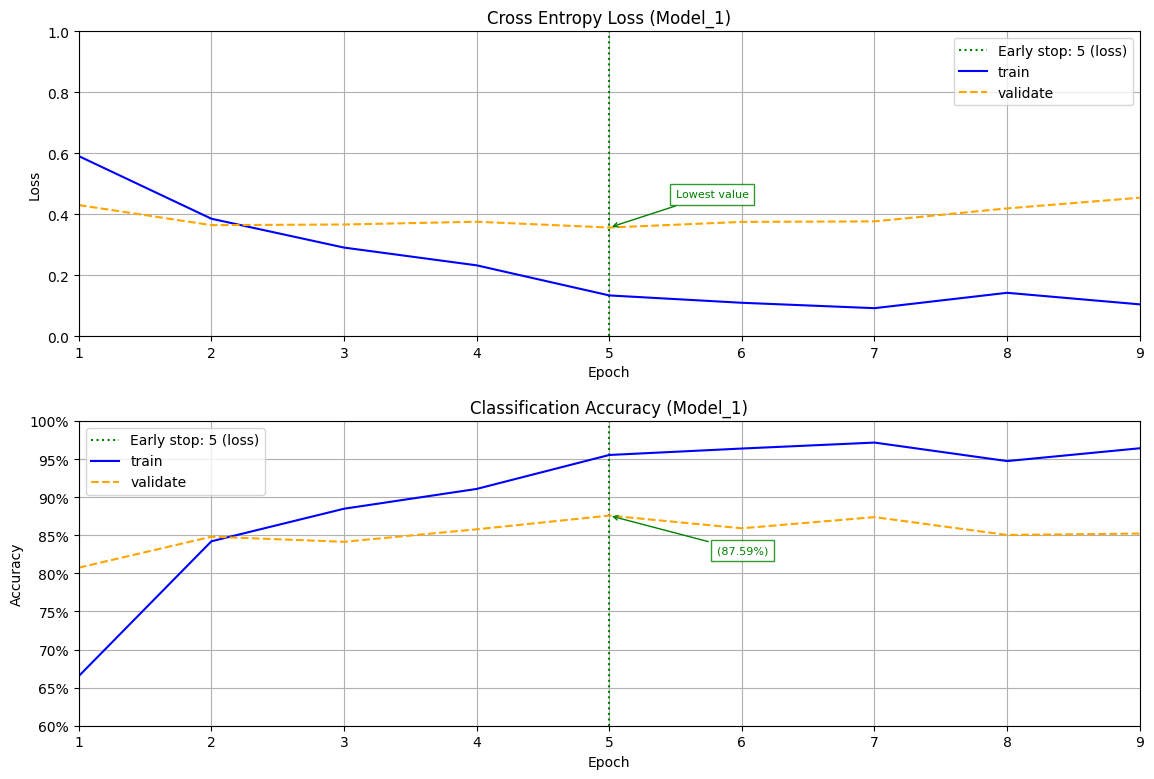

Summarize for: (Model_2)
closest_epoch_index=3, stop_dist=7


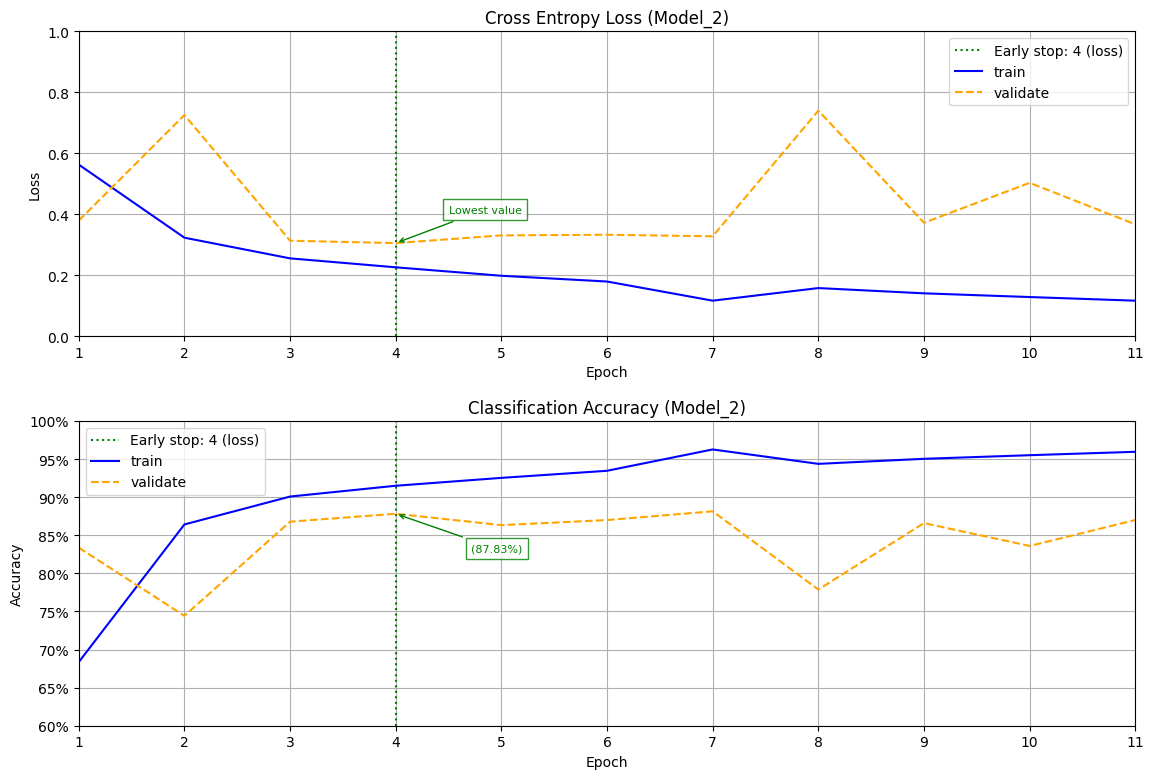

Summarize for: (Model_3)
closest_epoch_index=2, stop_dist=8


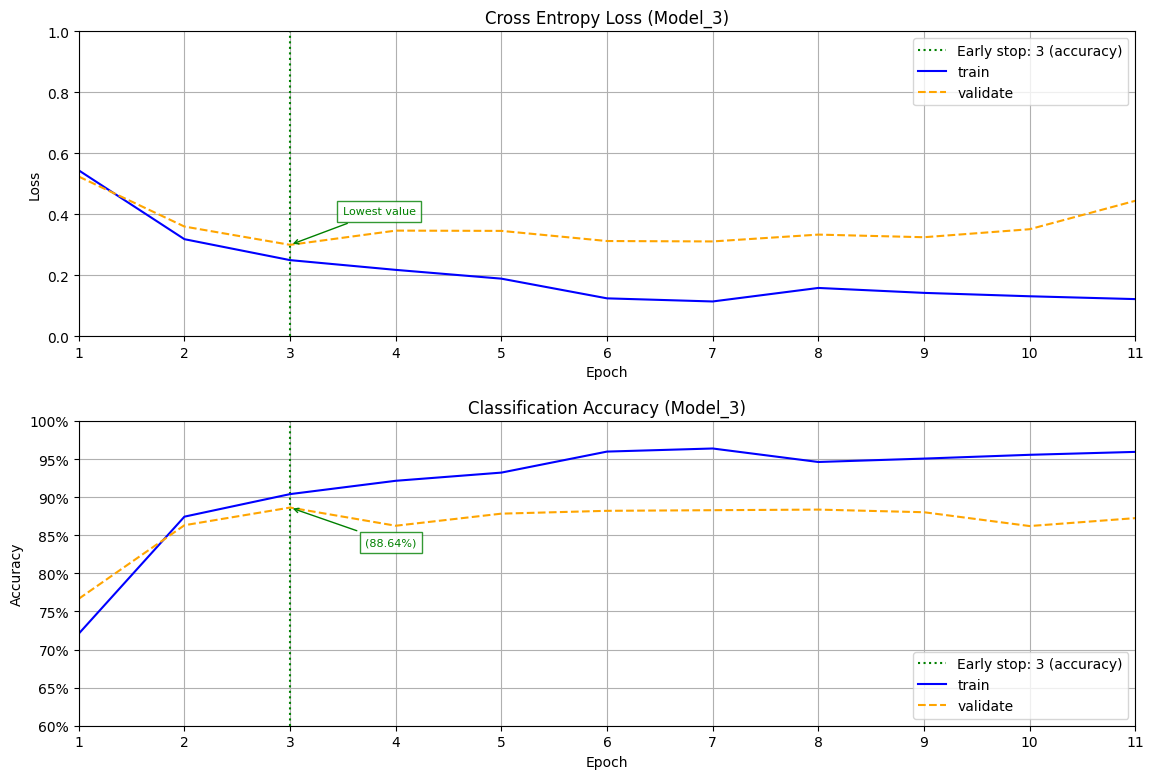

Summarize for: (Model_4)
closest_epoch_index=3, stop_dist=5


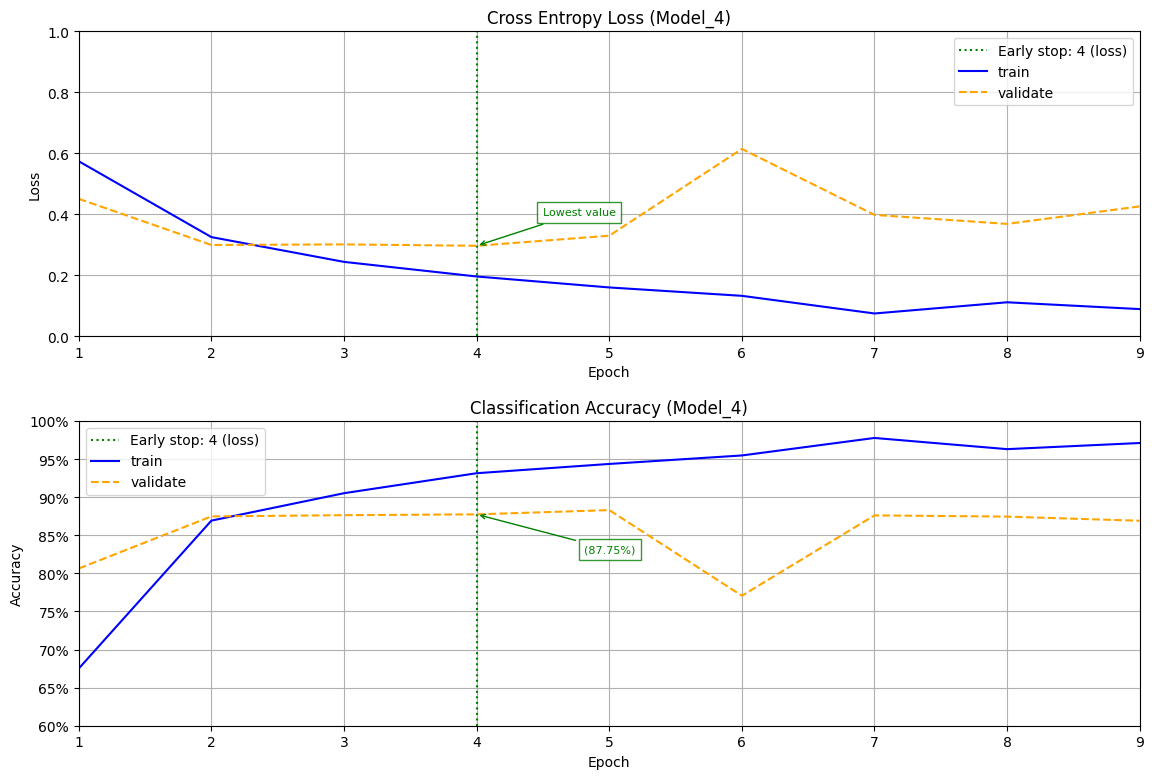

Summarize for: (Model_5)
closest_epoch_index=2, stop_dist=7


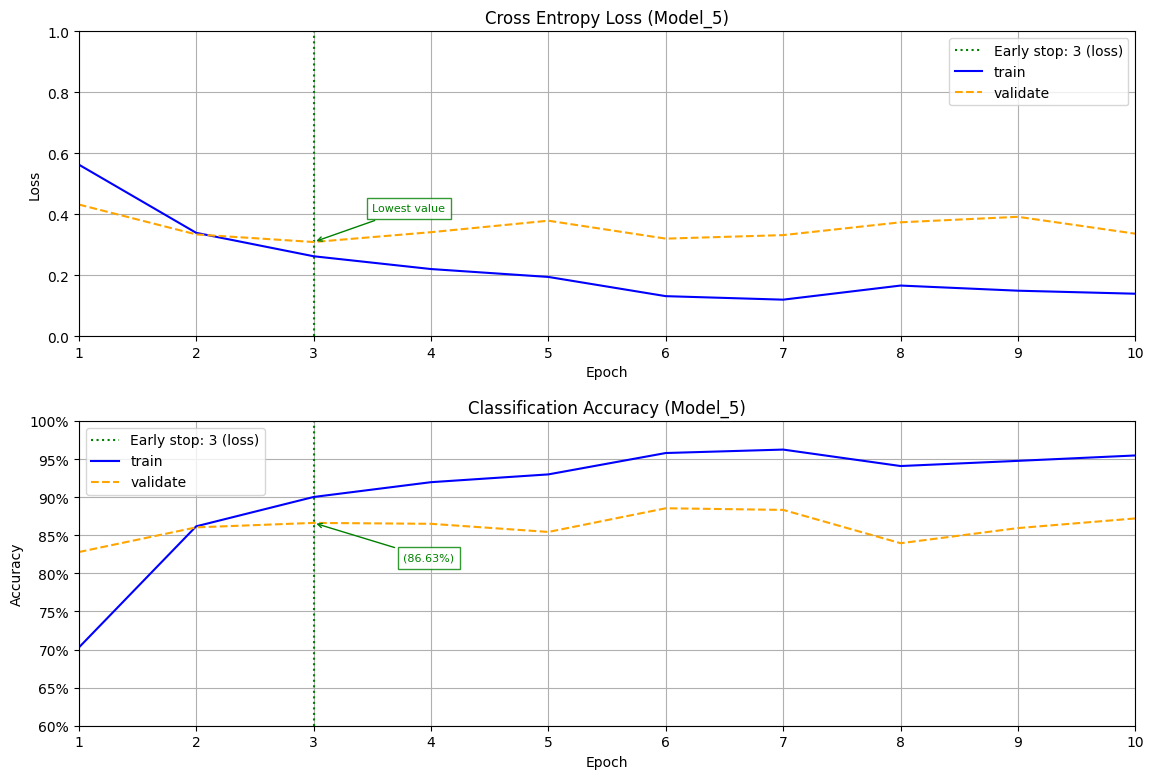

Summarize for: (Model_1_a)
closest_epoch_index=3, stop_dist=5


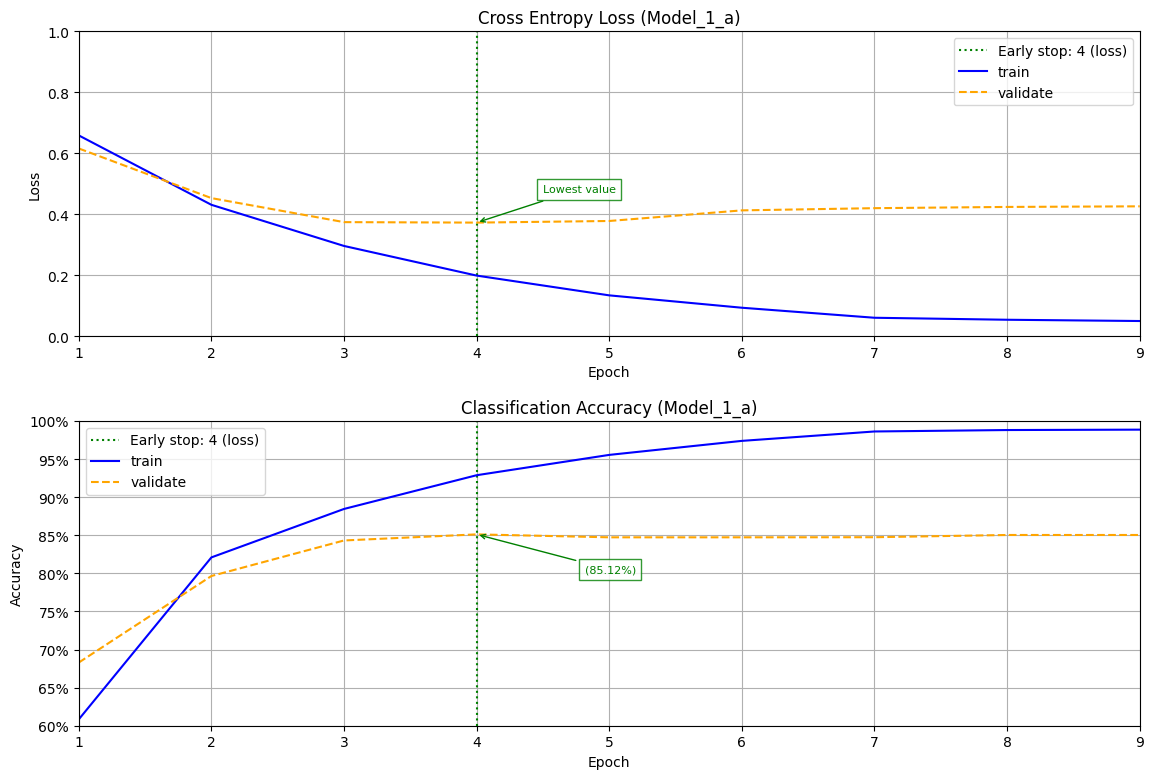

Summarize for: (Model_2_a)
closest_epoch_index=2, stop_dist=6


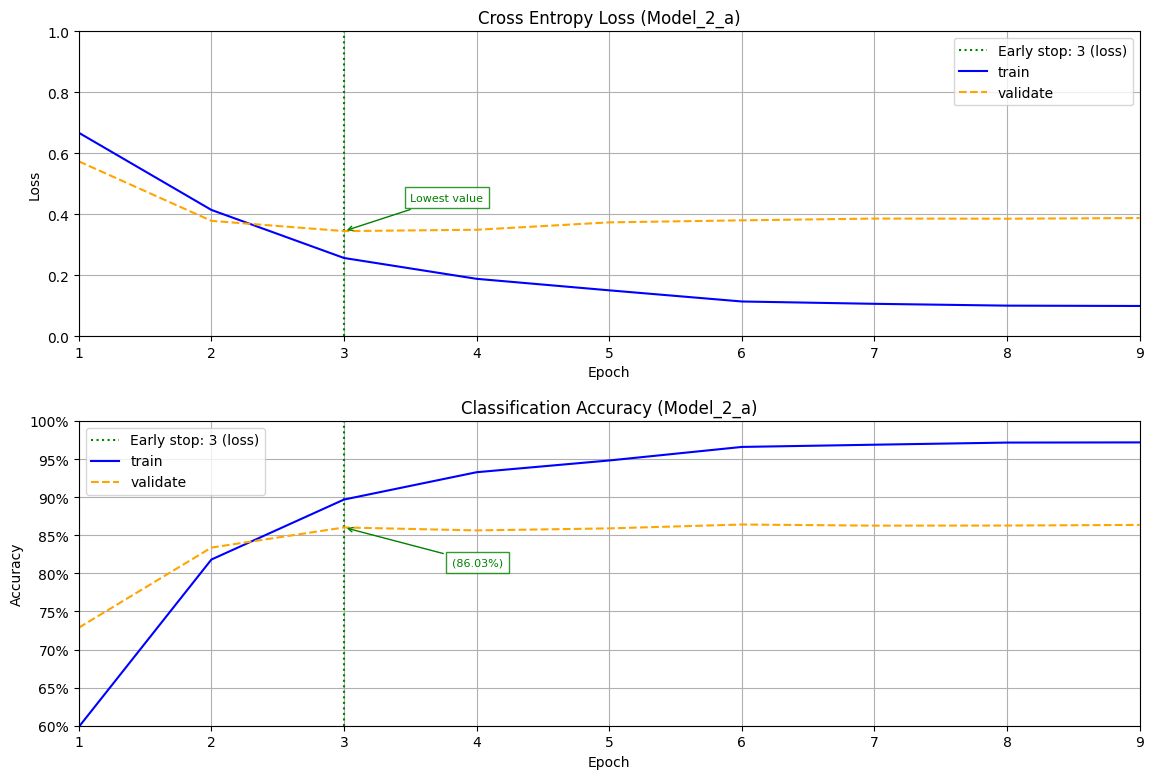

Summarize for: (Model_3_a)
closest_epoch_index=3, stop_dist=5


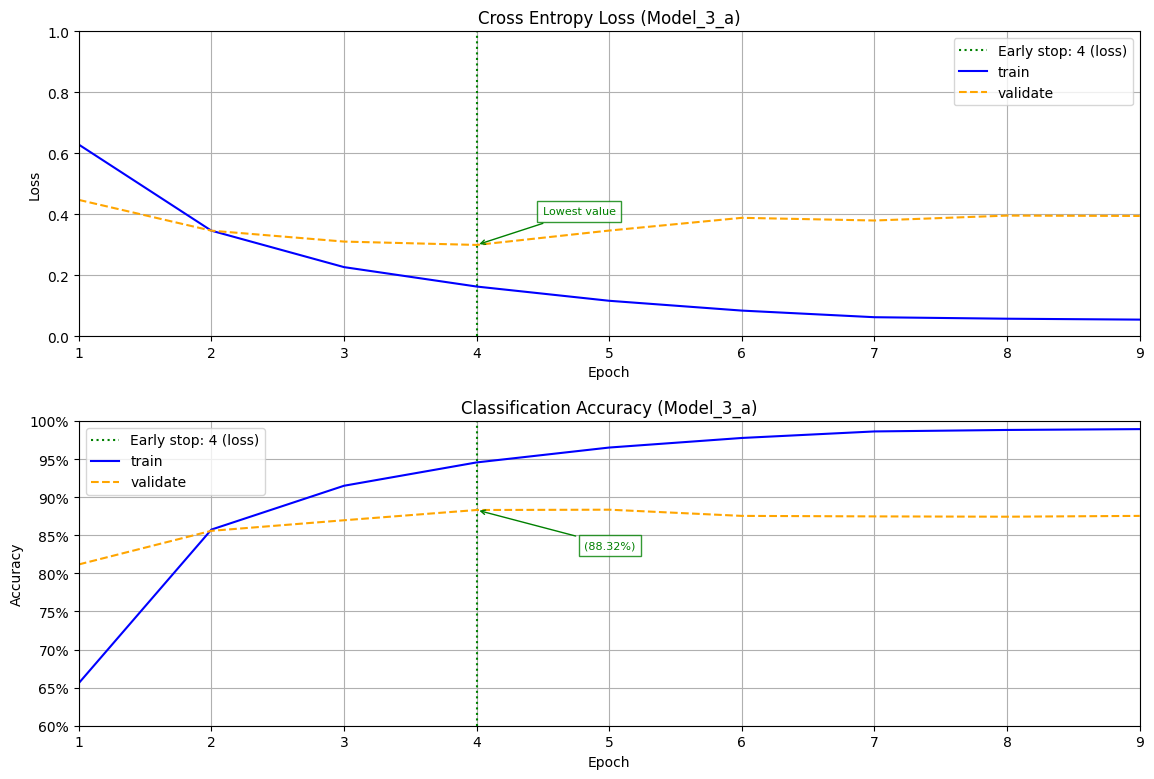

Summarize for: (Model_4_a)
closest_epoch_index=2, stop_dist=6


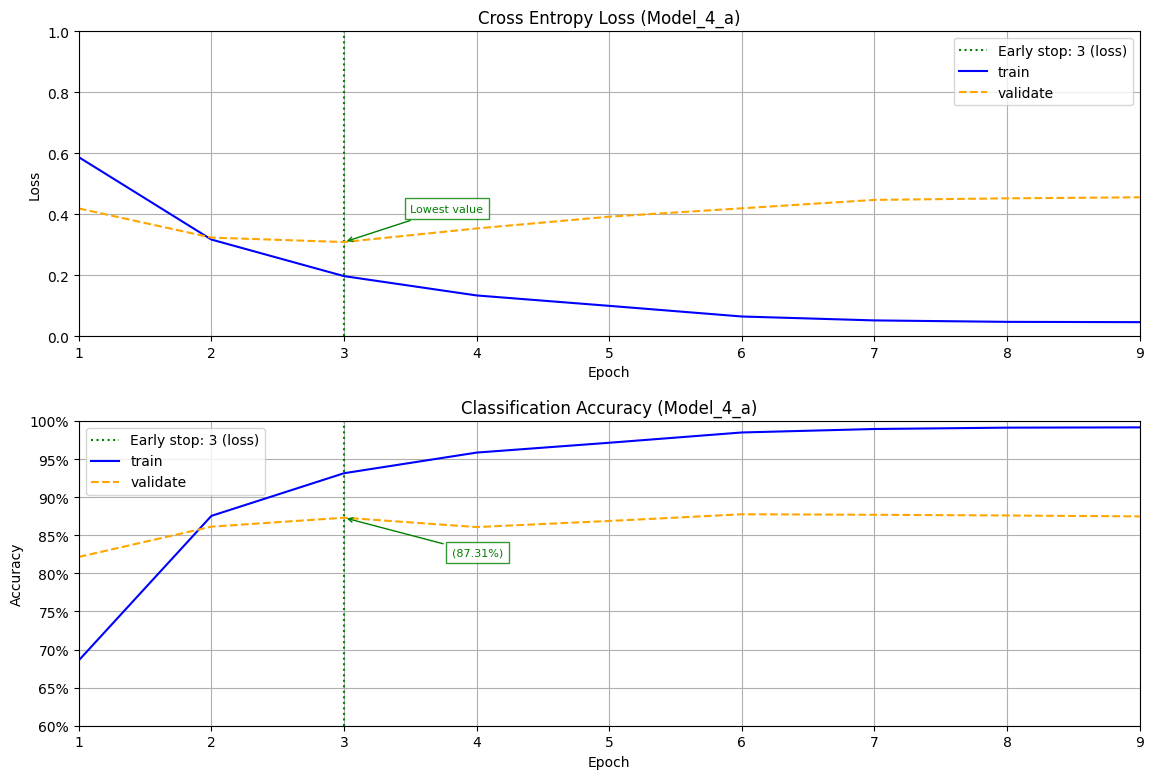

Summarize for: (Model_5_a)
closest_epoch_index=6, stop_dist=4


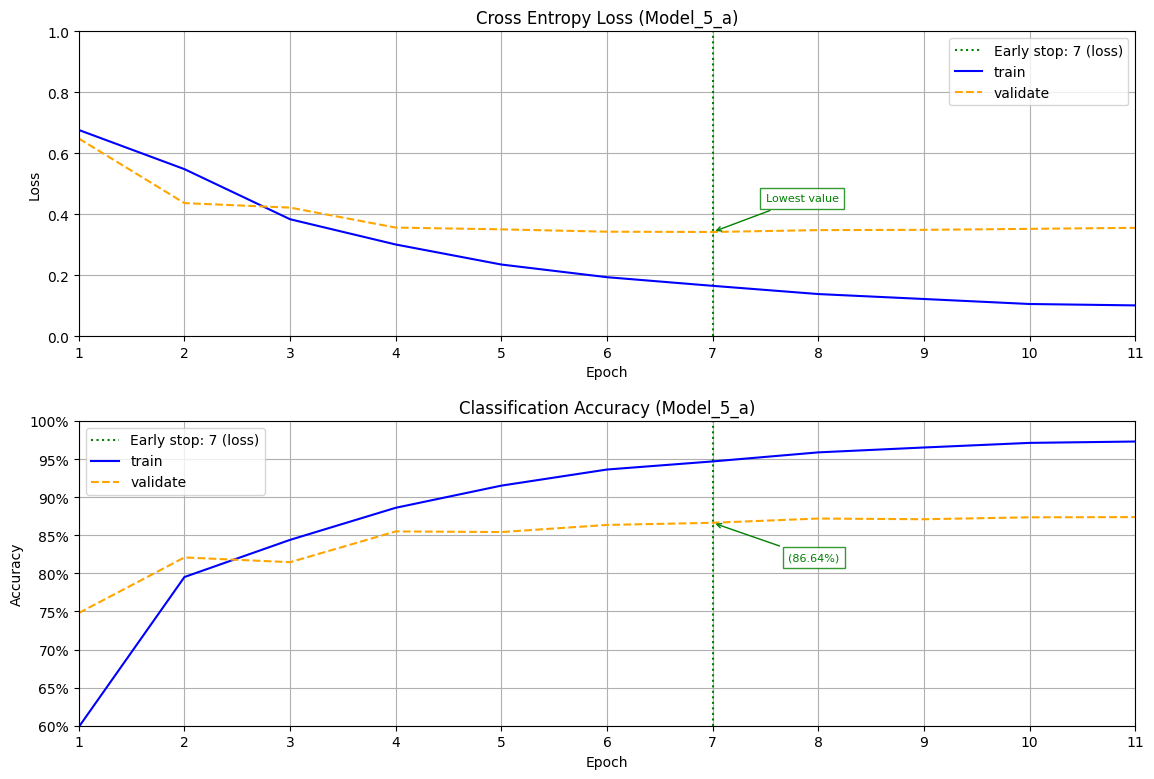

Summarize for: (Model_1_b)
closest_epoch_index=4, stop_dist=4


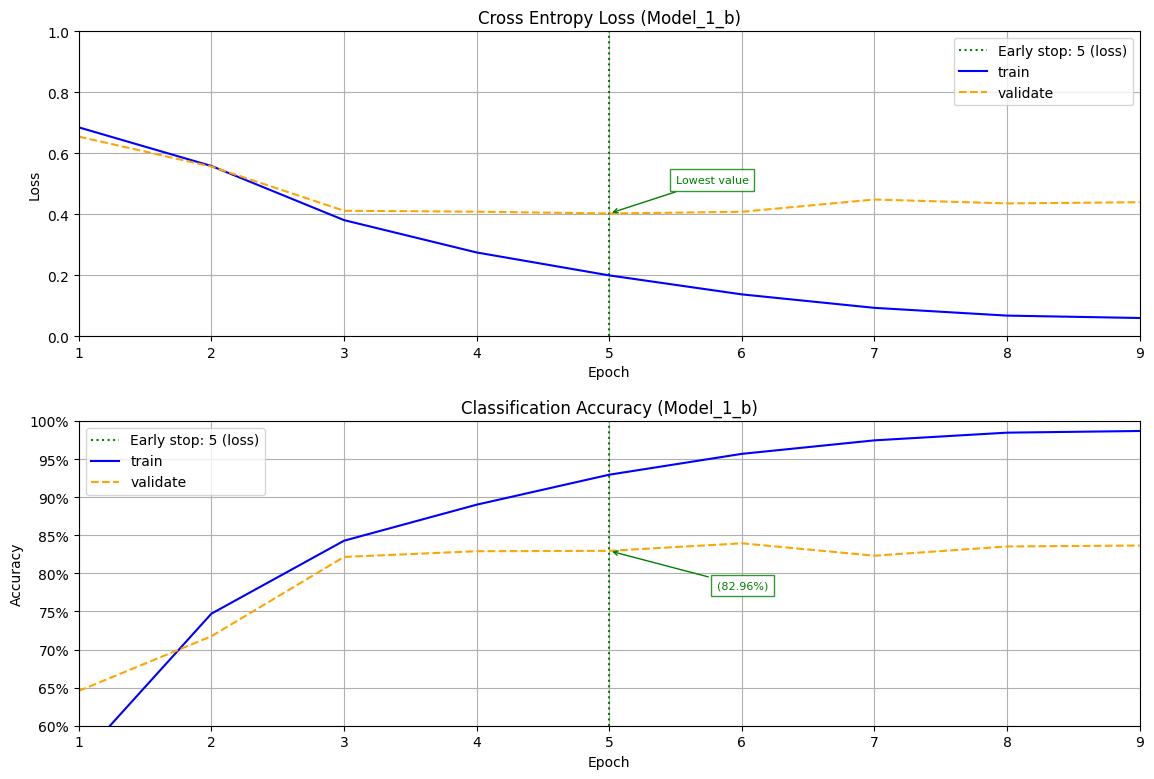

Summarize for: (Model_2_b)
closest_epoch_index=2, stop_dist=7


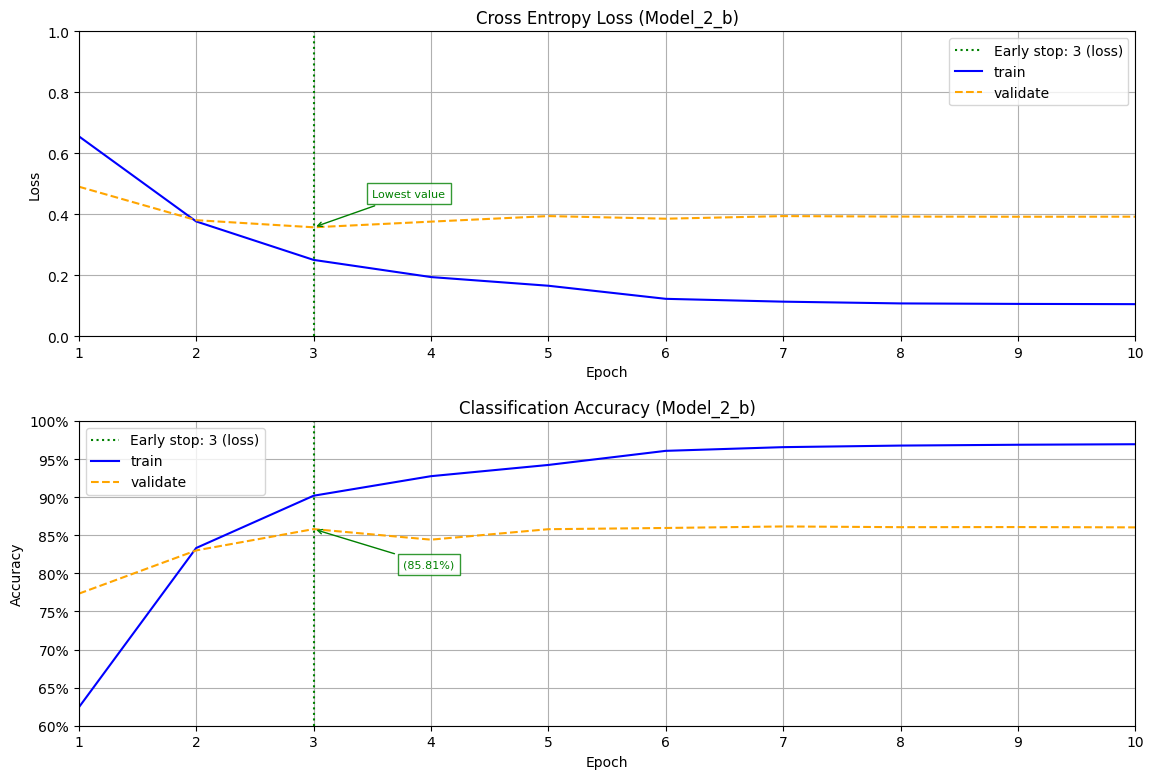

Summarize for: (Model_3_b)
closest_epoch_index=3, stop_dist=5


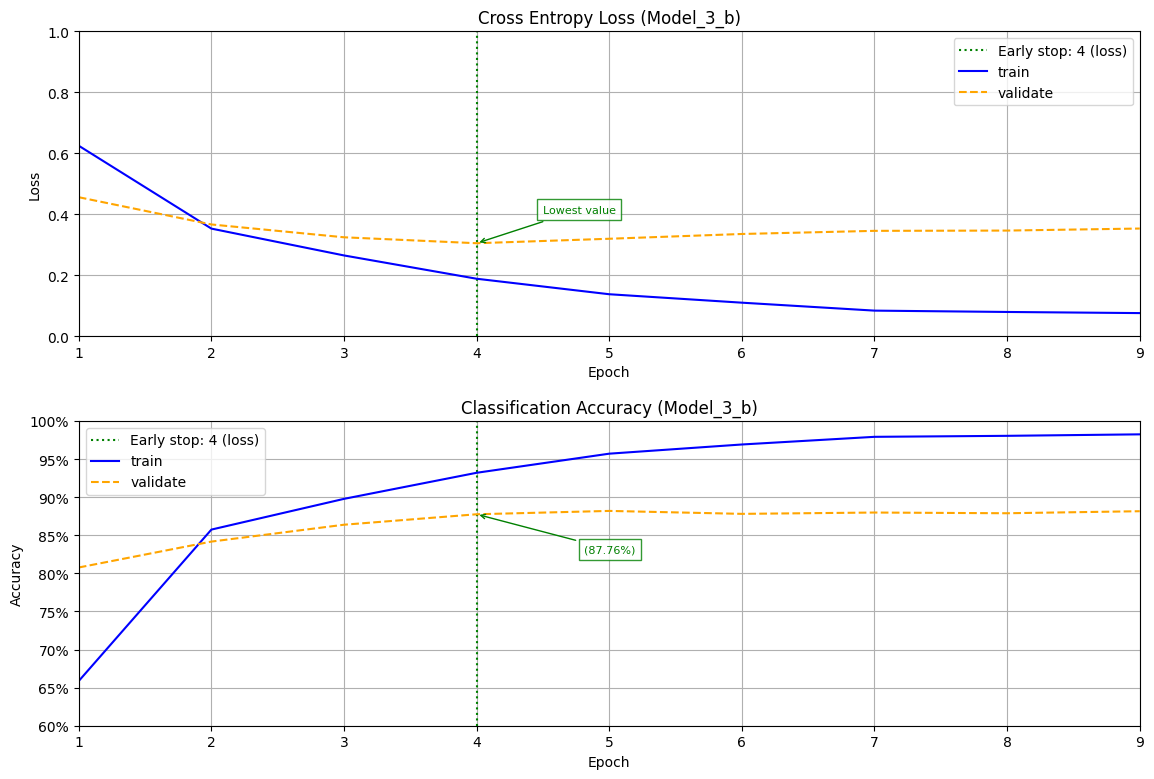

Summarize for: (Model_4_b)
closest_epoch_index=2, stop_dist=7


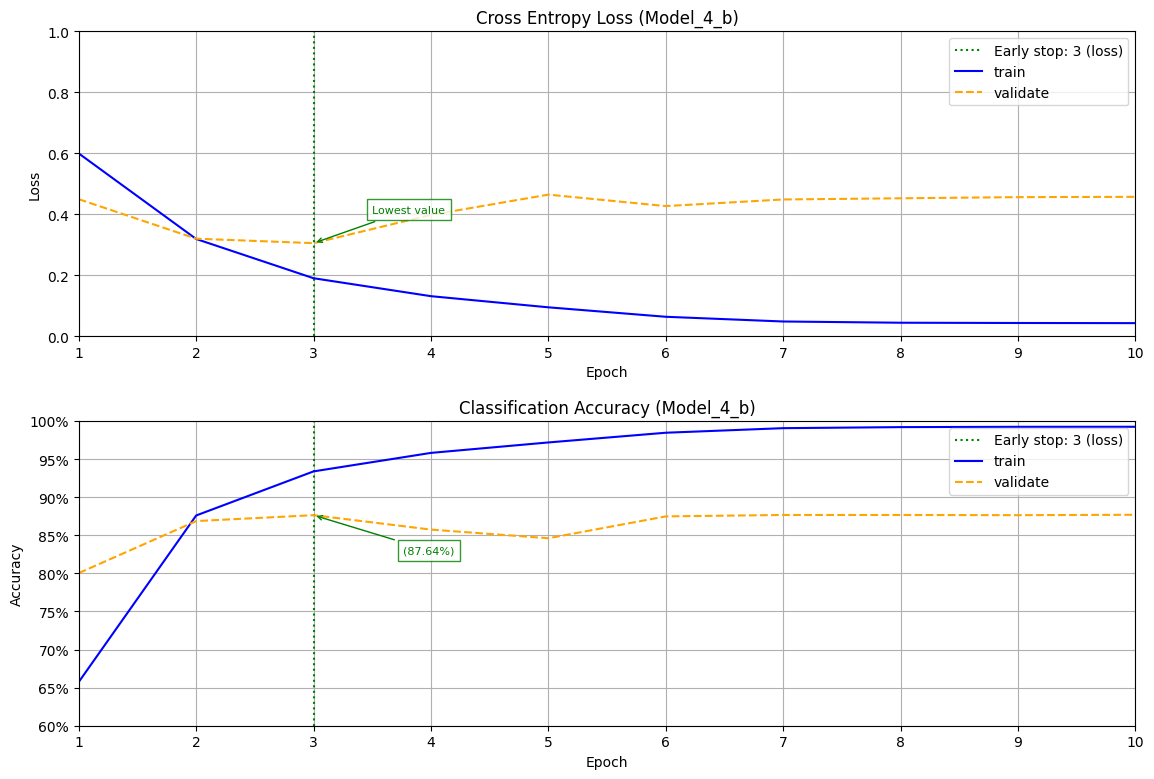

Summarize for: (Model_5_b)
closest_epoch_index=4, stop_dist=4


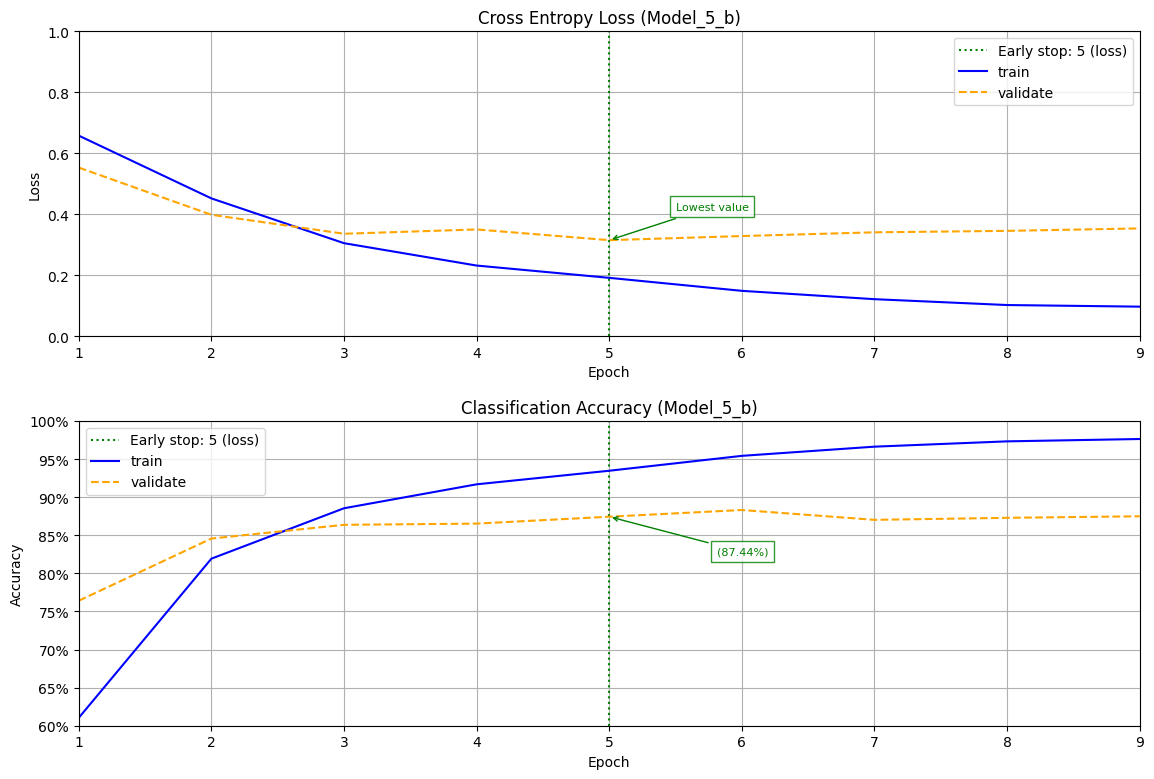

Summarize for: (Model_1_c)
closest_epoch_index=9, stop_dist=4


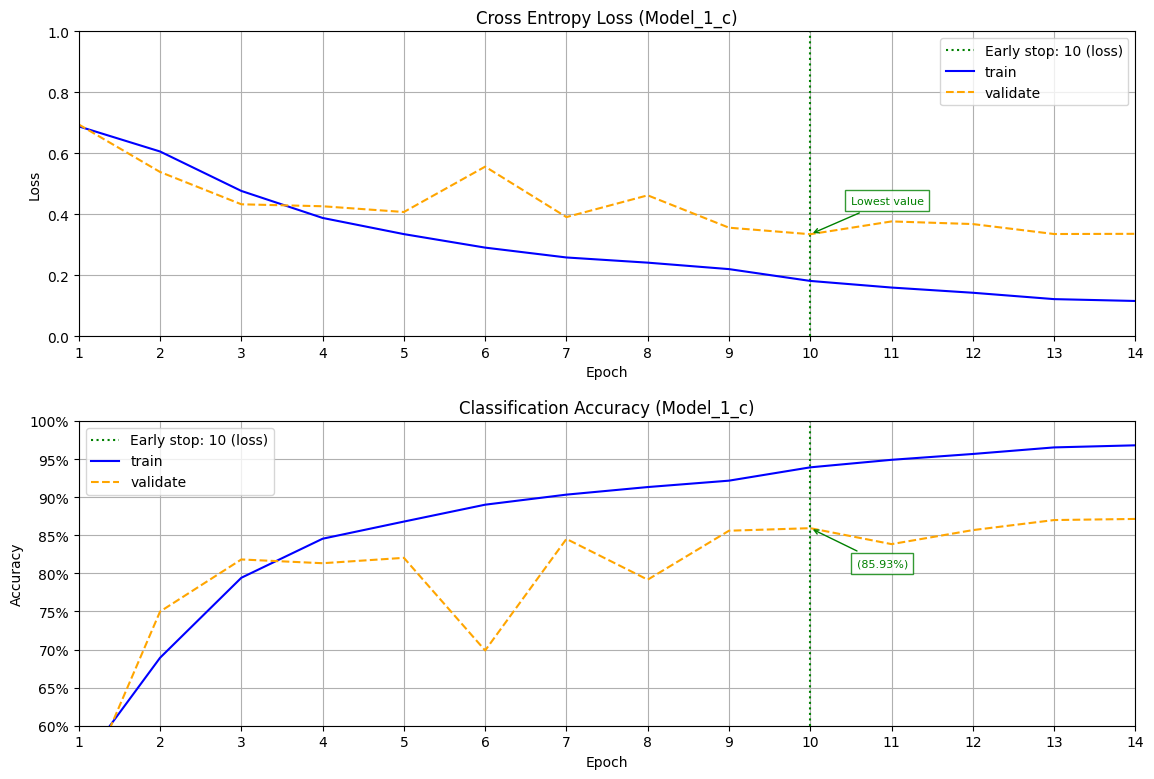

Summarize for: (Model_2_c)
closest_epoch_index=12, stop_dist=4


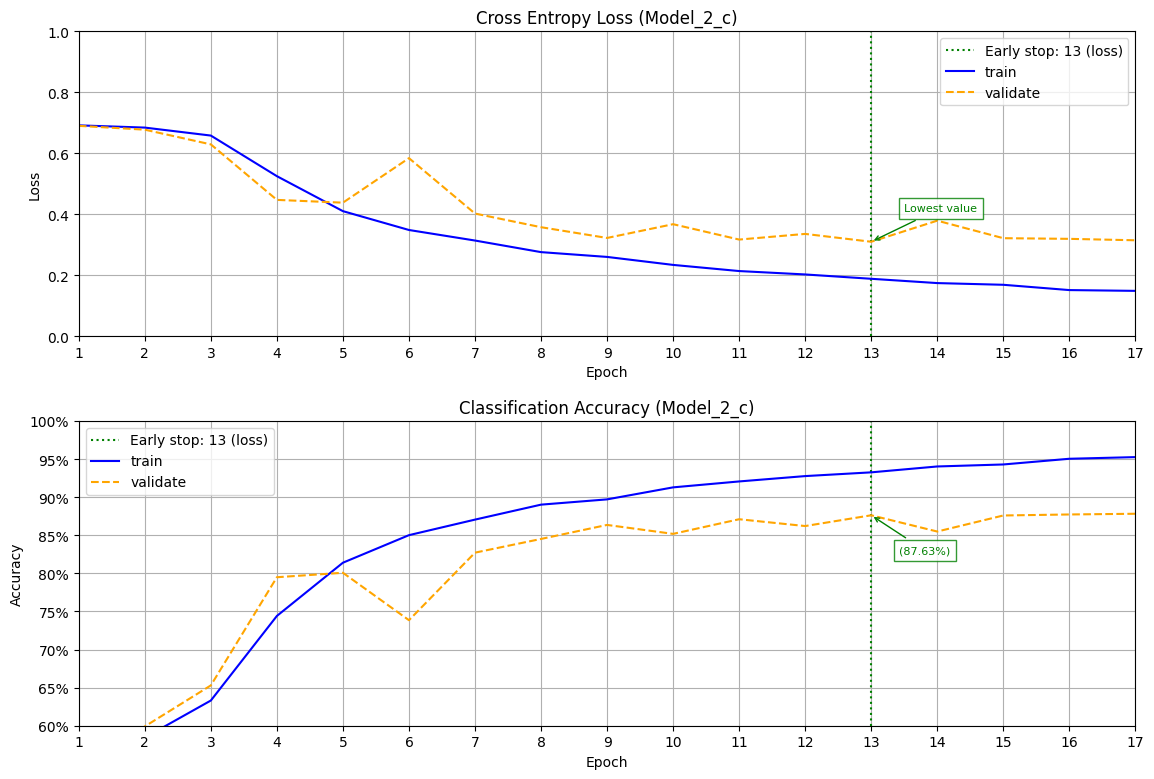

Summarize for: (Model_3_c)
closest_epoch_index=13, stop_dist=4


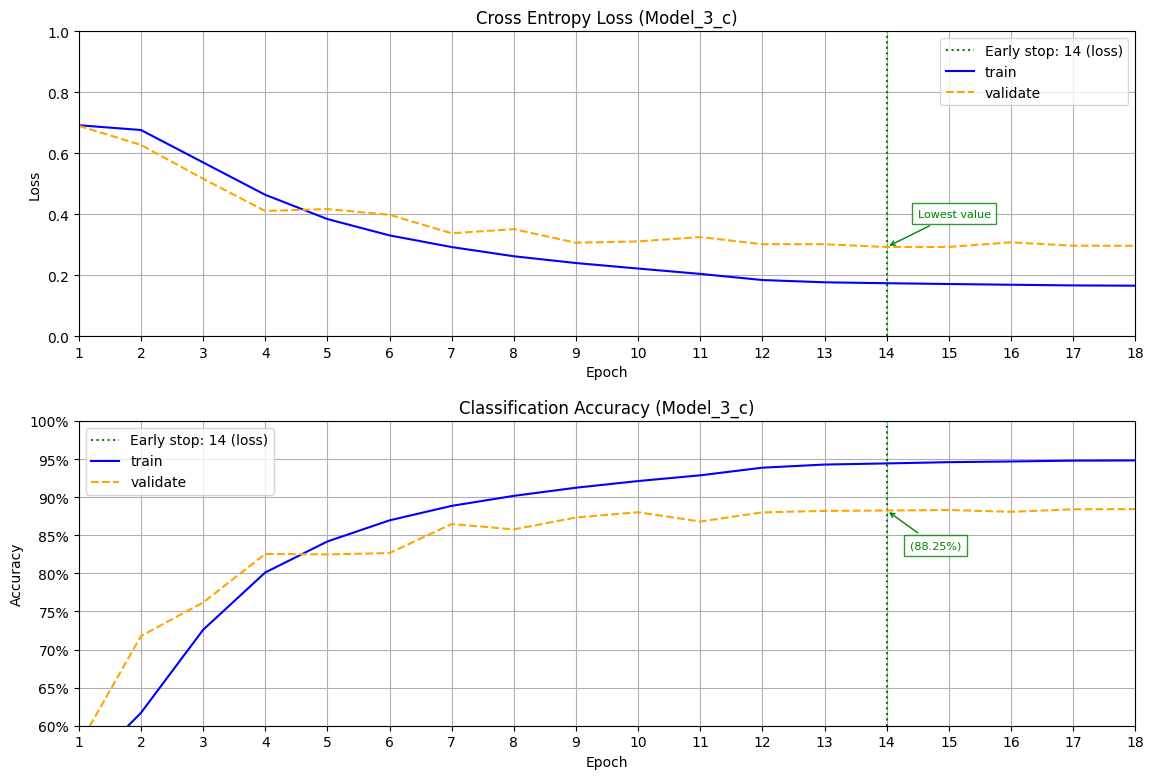

Summarize for: (Model_4_c)
closest_epoch_index=10, stop_dist=4


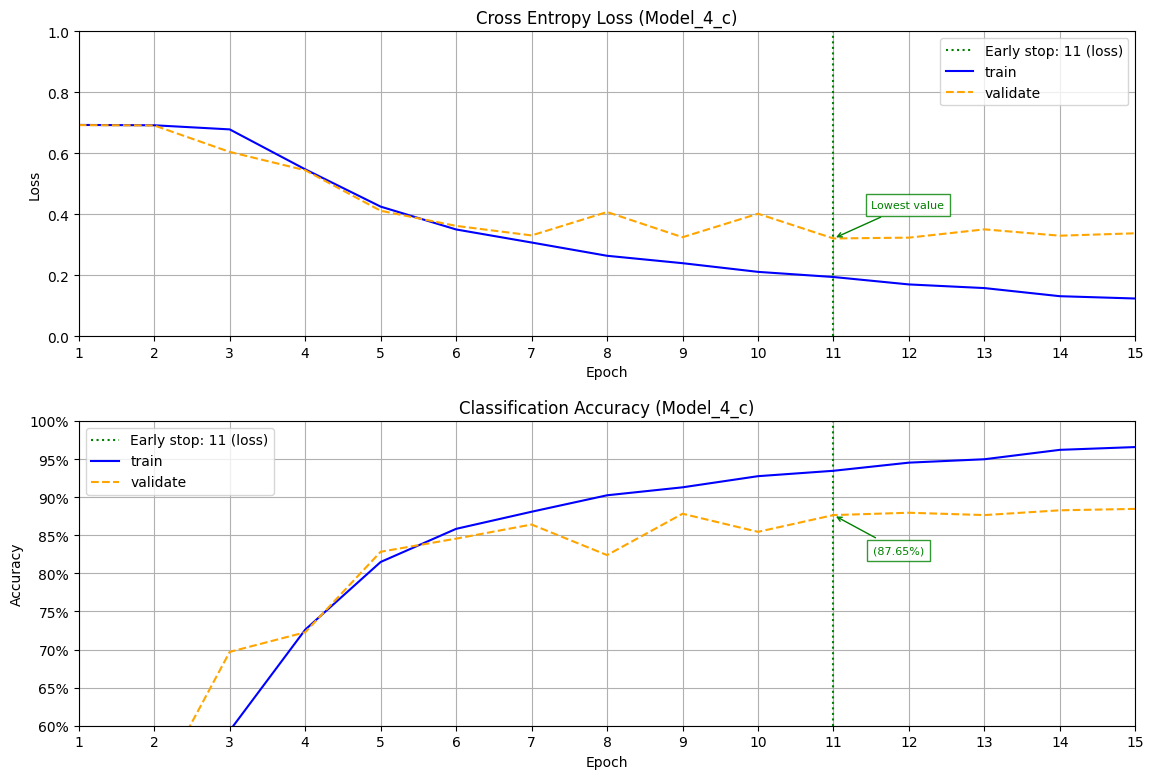

Summarize for: (Model_5_c)
closest_epoch_index=11, stop_dist=4


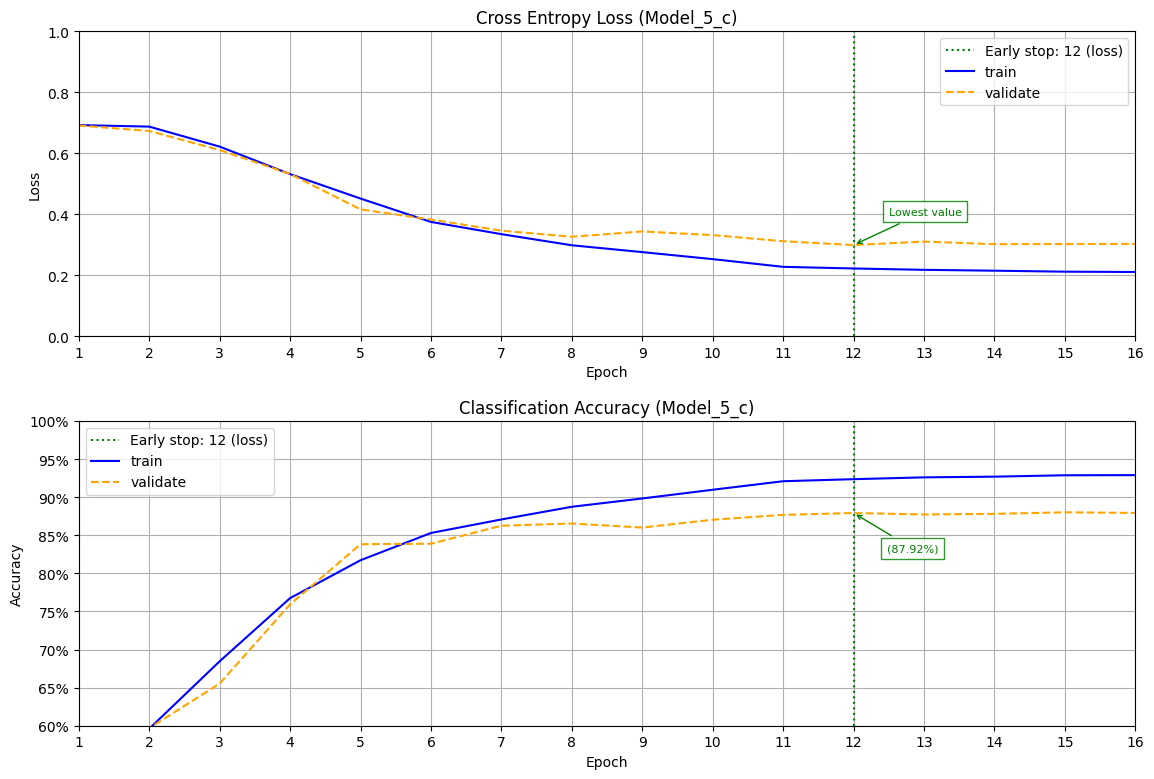

In [40]:
for name, models_h in models_his.items():
  #print(name)
  summarize(models_h, f"({name})", results[name])

## Reports

In [41]:
def load_pred_all():
  if ignore_saved_model:
    return None, None
  test_pred, test_pred_values = None, None
  filepath=Path("models_test_pred.pkl")
  if filepath.exists():
    with filepath.open('rb') as f:
        test_pred = pickle.load(f)
  if filepath.exists():
    filepath=Path("models_test_pred_values.pkl")
    with filepath.open('rb') as f:
        test_pred_values = pickle.load(f)
  return test_pred, test_pred_values

  # test_pred, test_pred_values = load_pred_all()


In [42]:
test_pred_values = {}
test_pred = {}
need_use_prepared_data = ['Model_1']

for name, models_h in models_his.items():
  print(f'"{name}" based on ({models_dnn[name].name})')
  try:
    test_pred_, test_pred_values_ = load_pred(name)
    if test_pred_ is None or test_pred_values_ is None:
      x = x_test
      test_pred[name] = models_dnn[name].predict(x, batch_size=batch_size, use_multiprocessing=True)
      test_pred_values[name] = np.where( test_pred[name] > 0.5, 1.0, 0.0)
      save_pred(name)
    else:
      test_pred[name] = test_pred_
      test_pred_values[name] = test_pred_values_
      print("* Restored form file store")
  except ValueError as err:
    print("  ** Skiped. ", 'May be some layer is incompatible with the expected shape')



"Model_1" based on (Model_1)
* Restored form file store
"Model_2" based on (Model_2)
* Restored form file store
"Model_3" based on (Model_3)
* Restored form file store
"Model_4" based on (Model_4)
49/49 [==============================] - 3s 35ms/step
Saved test_pred
Saved test_pred_values
"Model_5" based on (Model_5)
49/49 [==============================] - 1s 15ms/step
Saved test_pred
Saved test_pred_values
"Model_1_a" based on (Model_1)
49/49 [==============================] - 2s 36ms/step
Saved test_pred
Saved test_pred_values
"Model_2_a" based on (Model_2)
49/49 [==============================] - 1s 9ms/step
Saved test_pred
Saved test_pred_values
"Model_3_a" based on (Model_3)
49/49 [==============================] - 1s 10ms/step
Saved test_pred
Saved test_pred_values
"Model_4_a" based on (Model_4)
49/49 [==============================] - 3s 35ms/step
Saved test_pred
Saved test_pred_values
"Model_5_a" based on (Model_5)
49/49 [==============================] - 1s 15ms/step
Saved te

In [43]:
test_pred[name]

array([[0.12068354],
       [0.95532876],
       [0.79537004],
       ...,
       [0.07873319],
       [0.23000212],
       [0.7769324 ]], dtype=float32)

In [44]:
test_pred_values[name]

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [45]:
test_pred[name].shape

(25000, 1)

In [46]:
test_pred_values[name].shape

(25000, 1)

Classification report for: 'Model_1'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 86.96%, ROC-AUC: 0.9313

Confusion matrix for: 'Model_1'


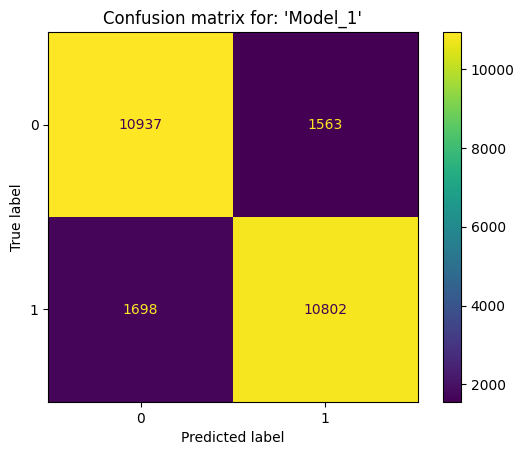

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_2'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 87.09%, ROC-AUC: 0.9416

Confusion matrix for: 'Model_2'


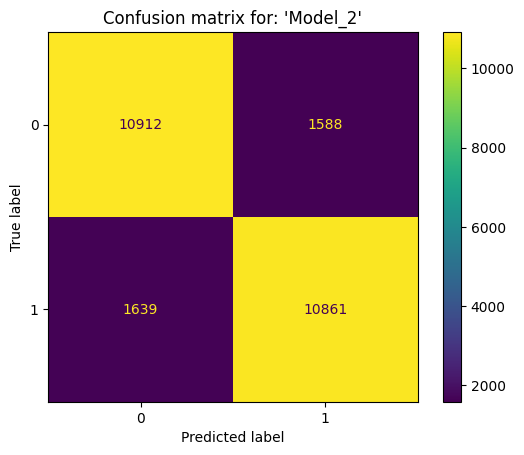

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_3'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12500
           1       0.87      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 87.94%, ROC-AUC: 0.9477

Confusion matrix for: 'Model_3'


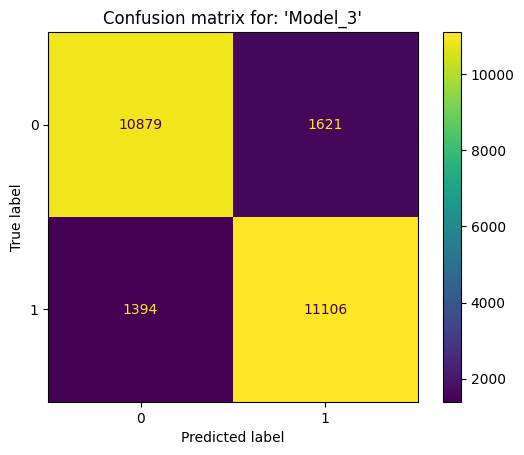

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_4'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     12500
           1       0.90      0.85      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 87.53%, ROC-AUC: 0.9452

Confusion matrix for: 'Model_4'


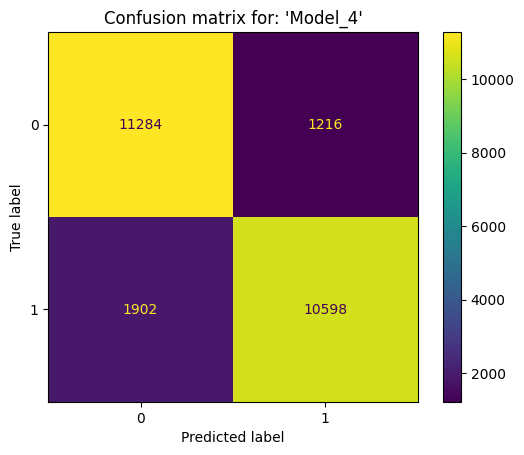

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_5'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     12500
           1       0.86      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 87.62%, ROC-AUC: 0.9454

Confusion matrix for: 'Model_5'


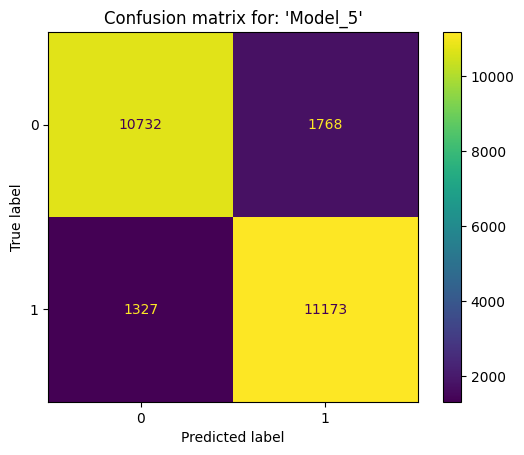

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_1_a'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy: 84.07%, ROC-AUC: 0.9158

Confusion matrix for: 'Model_1_a'


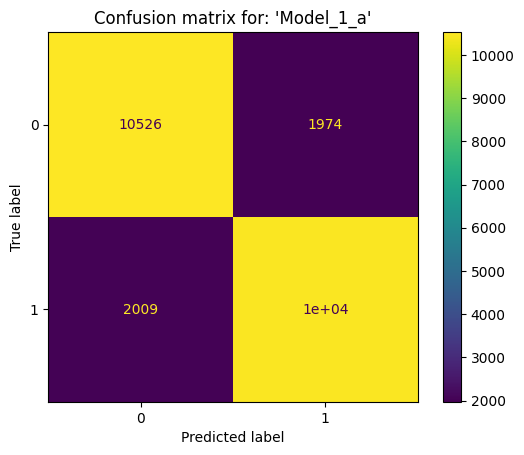

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_2_a'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     12500
           1       0.84      0.88      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 85.62%, ROC-AUC: 0.9275

Confusion matrix for: 'Model_2_a'


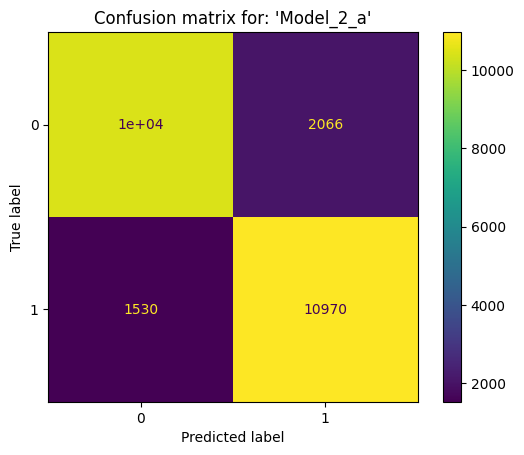

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_3_a'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.85      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 86.66%, ROC-AUC: 0.9399

Confusion matrix for: 'Model_3_a'


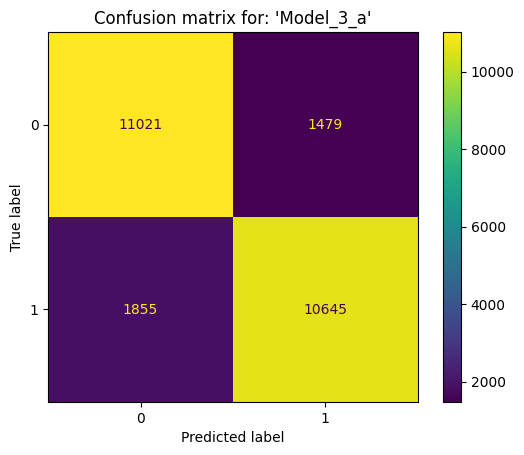

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_4_a'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     12500
           1       0.89      0.82      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 86.11%, ROC-AUC: 0.9384

Confusion matrix for: 'Model_4_a'


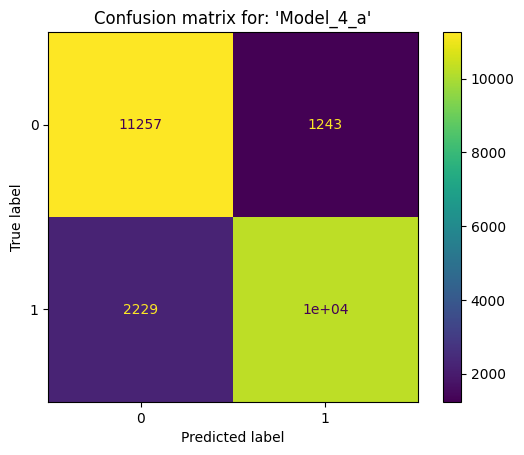

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_5_a'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.87      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 85.60%, ROC-AUC: 0.9315

Confusion matrix for: 'Model_5_a'


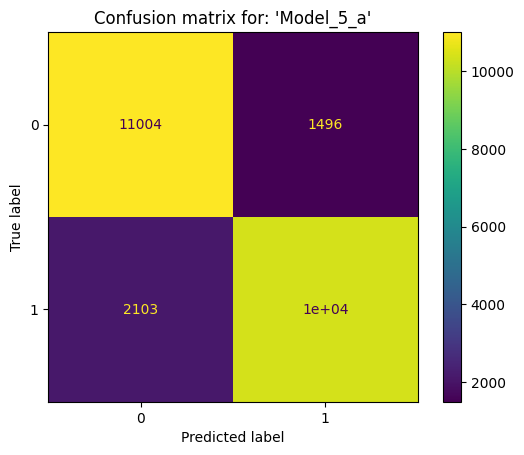

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_1_b'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12500
           1       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Accuracy: 82.95%, ROC-AUC: 0.9035

Confusion matrix for: 'Model_1_b'


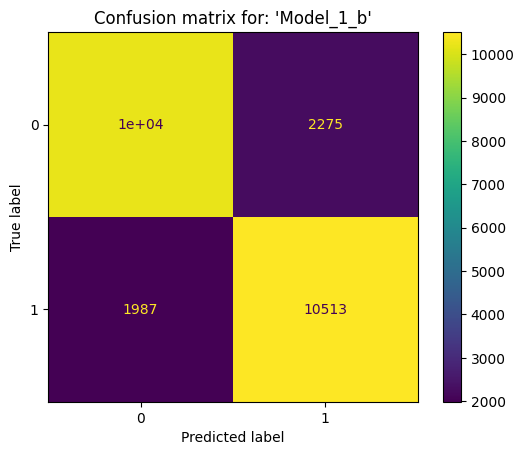

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_2_b'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Accuracy: 85.09%, ROC-AUC: 0.9249

Confusion matrix for: 'Model_2_b'


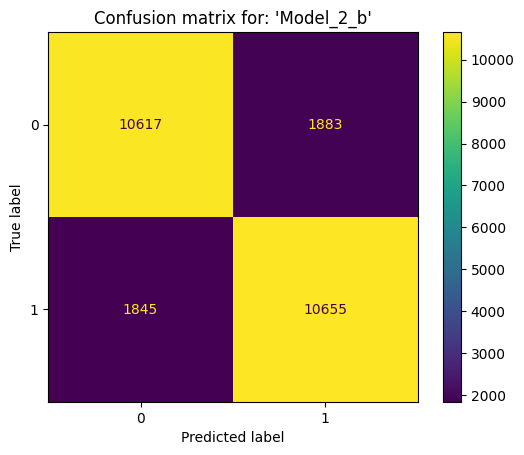

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_3_b'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 87.12%, ROC-AUC: 0.9417

Confusion matrix for: 'Model_3_b'


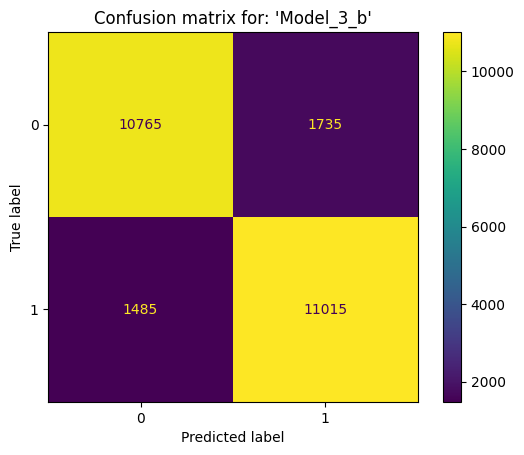

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_4_b'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     12500
           1       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 86.76%, ROC-AUC: 0.9391

Confusion matrix for: 'Model_4_b'


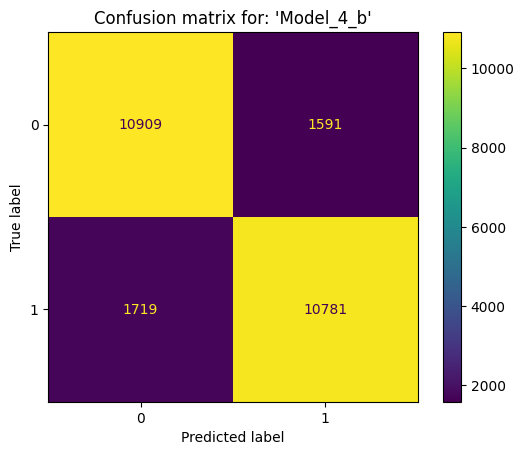

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_5_b'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     12500
           1       0.88      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000

Accuracy: 86.47%, ROC-AUC: 0.9363

Confusion matrix for: 'Model_5_b'


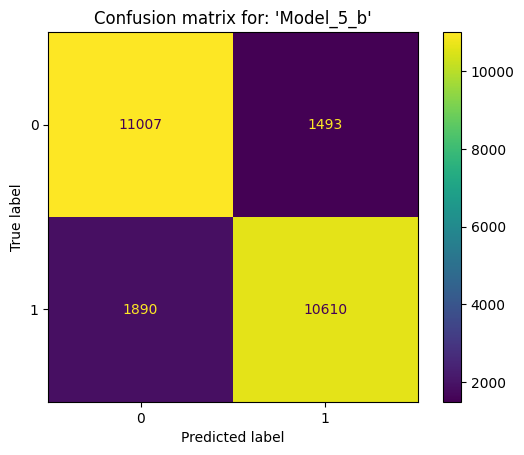

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_1_c'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     12500
           1       0.88      0.83      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 86.02%, ROC-AUC: 0.9320

Confusion matrix for: 'Model_1_c'


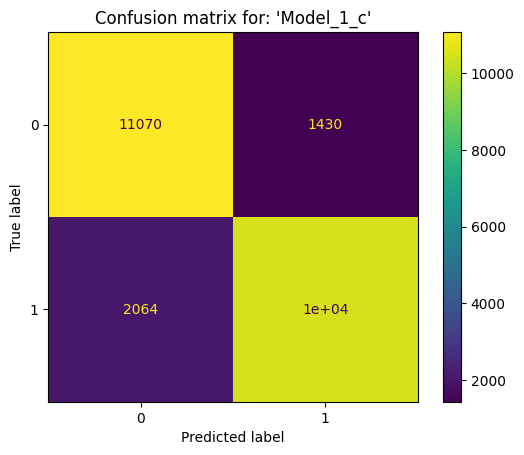

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_2_c'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 86.99%, ROC-AUC: 0.9418

Confusion matrix for: 'Model_2_c'


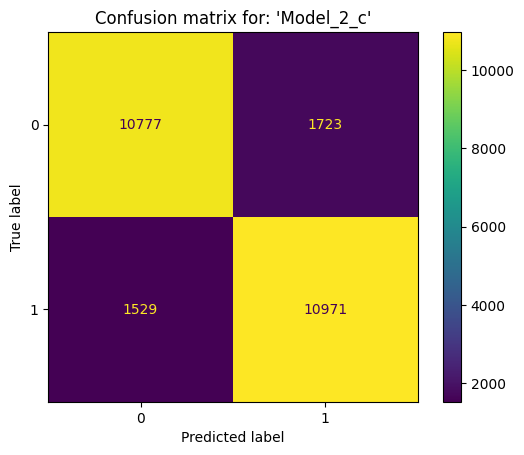

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_3_c'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     12500
           1       0.89      0.86      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 87.54%, ROC-AUC: 0.9481

Confusion matrix for: 'Model_3_c'


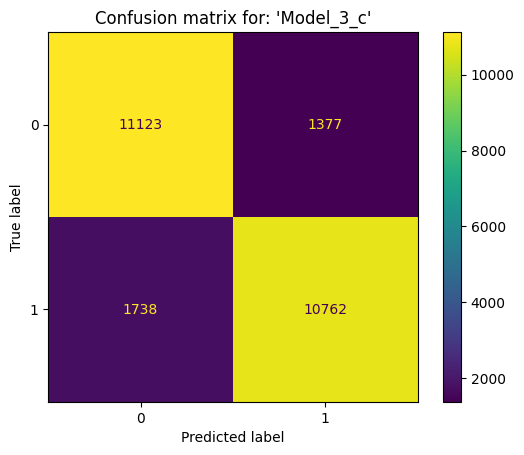

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_4_c'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     12500
           1       0.91      0.83      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 87.13%, ROC-AUC: 0.9487

Confusion matrix for: 'Model_4_c'


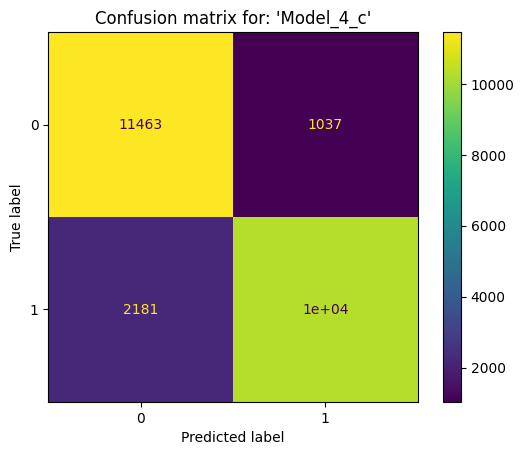

['0', '1']
------------------------------------------------------------ 

Classification report for: 'Model_5_c'
(25000,) (25000, 1)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.89      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy: 87.43%, ROC-AUC: 0.9454

Confusion matrix for: 'Model_5_c'


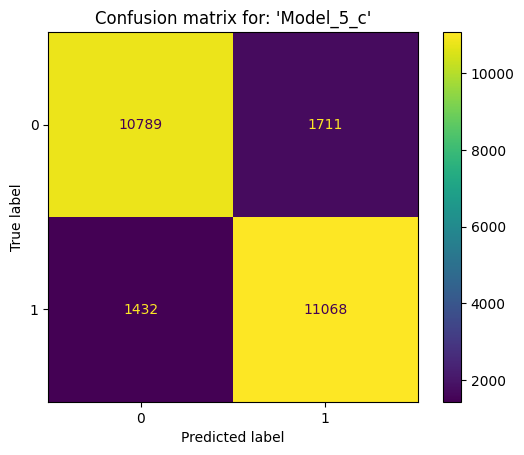

['0', '1']
------------------------------------------------------------ 



In [47]:
#target_names = [ f"{i} - {labels[i]:11}" for i in range(0, num_classes)]
target_names = ["0","1"]
moldel_roc_auc={}

for name in models_his.keys():
  print(f"Classification report for: '{name}'")
  try:
    y = y_test
    y_pred = test_pred_values[name]
    # if len(y.shape) !=  len(y_pred.shape):
    #   y = np.argmax(y_test, axis=1)
    #   # y_pred = test_pred[name]
    print(y.shape, y_pred.shape)
    print(classification_report(y, y_pred, target_names=target_names))
    cr = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    roc_auc = roc_auc_score(y, test_pred[name], multi_class='ovo')
    moldel_roc_auc[name] = roc_auc
    print(f'Accuracy: {cr["accuracy"]:.2%}, ROC-AUC: {roc_auc:.4f}')
    print(f"\nConfusion matrix for: '{name}'")
    confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Confusion matrix for: '{name}'")
    fname = f'img_{name}_cm.png'
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    print(list(map(lambda x: x.strip(),target_names)))
    print("-"*60,"\n")
  except (KeyError, ValueError) as err:
    print("ERROR", err)

In [48]:
# for name in models_his.keys():
#   fname = f'img_{name}_cm.png'
#   img = Path(fname)
#   if img.exists():
#     print(f'\n![Confusion matrix of ({name})]({fname})')

In [49]:
def md_print_helper_cm():
  print('| Model  | Model  | Model  |')
  print('|:------:|:------:|:------:|')
  i = 0
  id = 0
  cols = 3
  i_width = 235
  row=['','','']
  row_t=['','','']
  for name in models_his.keys():
    fname = f'img_{name}_cm.png'
    img = Path(fname)
    if img.exists():
      # md_img = f'![Confusion matrix of ({name})]({fname})'
      md_img = f'<img src="{fname}" alt="Confusion matrix of ({name})" width="{i_width}">'
      id = i % cols
      if id == 0:
        row=['','','']
        row_t=['','','']
      # print(f"{i=}, {id=}")
      row[id] = md_img
      row_t[id] = name
      if id == cols - 1:
        print("|", " | ".join(row), "|", sep=" ")
        print("|", " | ".join(row_t), "|", sep=" ")
      i += 1
  if id < cols - 1:
    print("|", " | ".join(row), "|", sep=" ")
    print("|", " | ".join(row_t), "|", sep=" ")

md_print_helper_cm()

| Model  | Model  | Model  |
|:------:|:------:|:------:|
| <img src="img_Model_1_cm.png" alt="Confusion matrix of (Model_1)" width="235"> | <img src="img_Model_2_cm.png" alt="Confusion matrix of (Model_2)" width="235"> | <img src="img_Model_3_cm.png" alt="Confusion matrix of (Model_3)" width="235"> |
| Model_1 | Model_2 | Model_3 |
| <img src="img_Model_4_cm.png" alt="Confusion matrix of (Model_4)" width="235"> | <img src="img_Model_5_cm.png" alt="Confusion matrix of (Model_5)" width="235"> | <img src="img_Model_1_a_cm.png" alt="Confusion matrix of (Model_1_a)" width="235"> |
| Model_4 | Model_5 | Model_1_a |
| <img src="img_Model_2_a_cm.png" alt="Confusion matrix of (Model_2_a)" width="235"> | <img src="img_Model_3_a_cm.png" alt="Confusion matrix of (Model_3_a)" width="235"> | <img src="img_Model_4_a_cm.png" alt="Confusion matrix of (Model_4_a)" width="235"> |
| Model_2_a | Model_3_a | Model_4_a |
| <img src="img_Model_5_a_cm.png" alt="Confusion matrix of (Model_5_a)" width="235"> | 

## Зберігаємо всі моделі

In [50]:
zip_files()

Creating goit_python_ds_hw_11_models.zip
Copy to GDrive: /content/drive/MyDrive/Colab Notebooks/GoIT/datasets/goit_python_ds_hw_11_models.zip


## Порівняння моделей за val. accur.

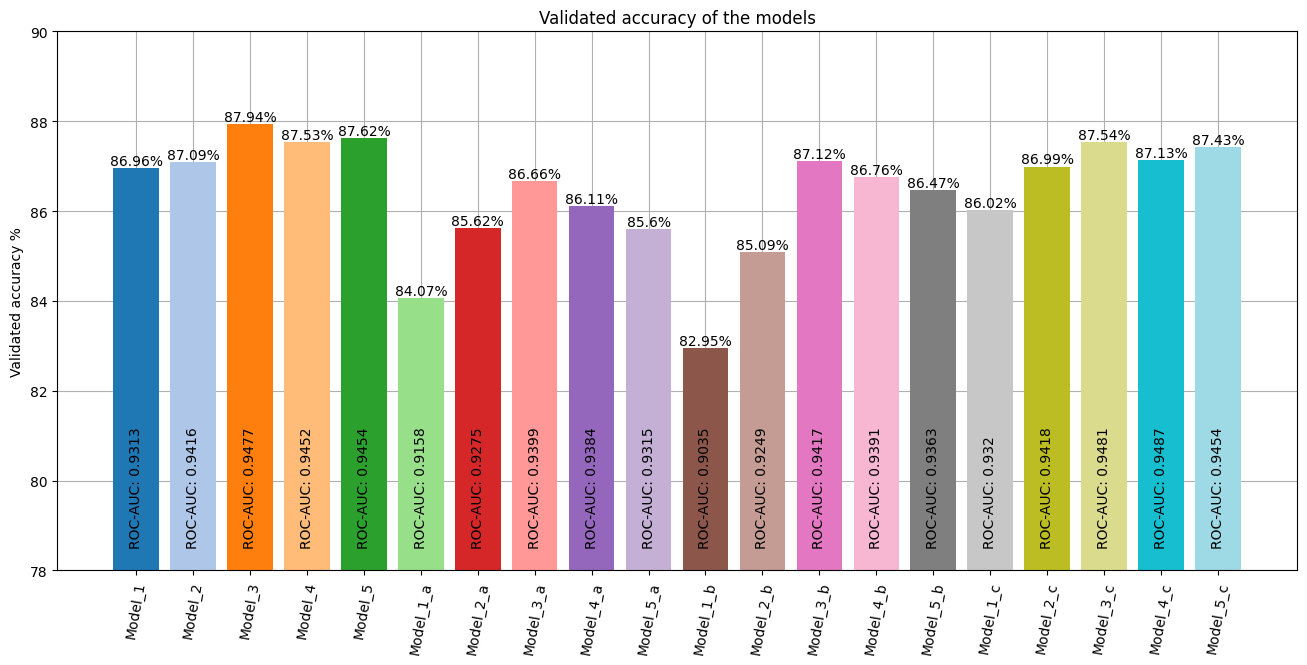

In [67]:
low_val=78
try:
  bar_y = [ results.get(m,(0.,0.8))[1]*100 for m in models_dnn ]
  ra_y = [ moldel_roc_auc.get(m,(0.)) for m in models_dnn ]

  plt.figure(figsize=(16,7))
  plt.grid()
  plt.gca().set_axisbelow(True)
  num_colors = len(models_dnn)
  colors = plt.cm.tab20(np.linspace(0, 1, num_colors))
  bars = plt.bar(x=models_dnn.keys(), height=bar_y, color=colors, width=.8) #plt.cm.tab20(colors)
  for bar, value, roc_auc in zip(bars, bar_y, ra_y):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4}%", ha='center', va='bottom', fontsize=10)
      if value > low_val + 3.5:
        plt.text(bar.get_x() + bar.get_width() / 2 , low_val + 0.5, f"ROC-AUC: {roc_auc:.4}", ha='center', va='bottom', fontsize=10, rotation=90)


  plt.ylim(low_val,90)
  plt.xticks(rotation=80)
  plt.title("Validated accuracy of the models")
  plt.ylabel("Validated accuracy %")
  plt.savefig(f'img_va.png', bbox_inches='tight')
  plt.show()
except KeyError as err:
  print(err)

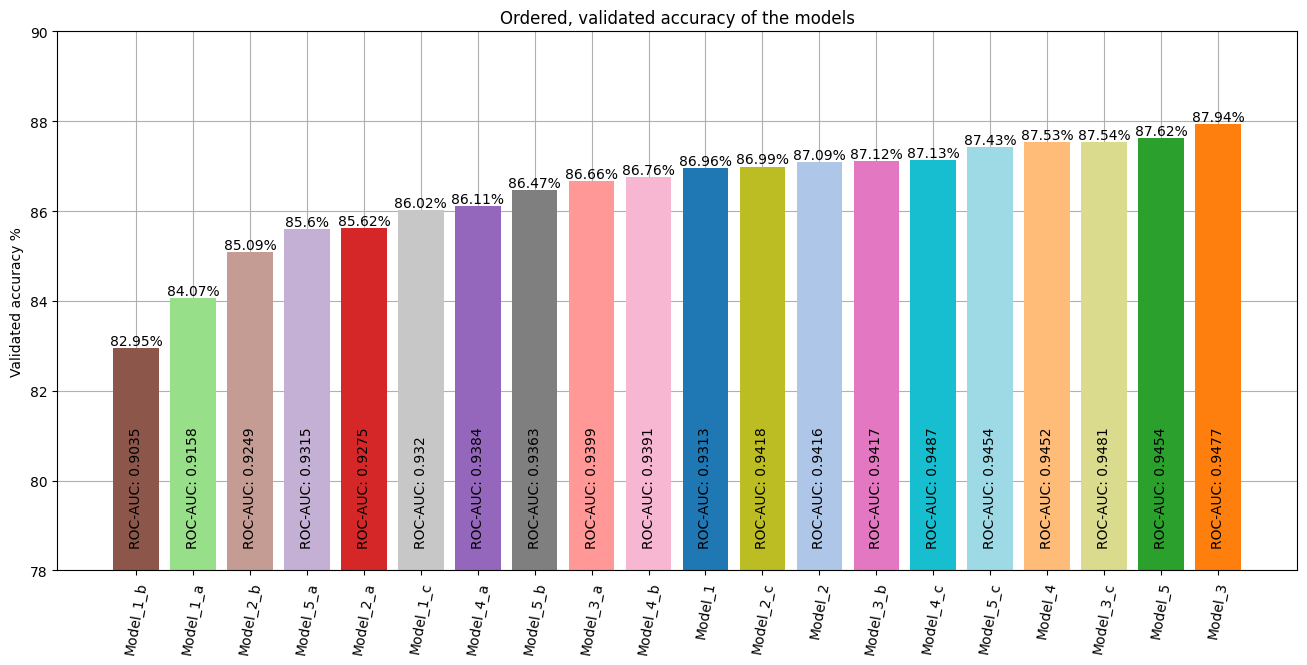

In [68]:
sorted_indices = sorted(range(len(bar_y)), key=lambda k: bar_y[k])
bar_x_s = [list(models_dnn.keys())[i] for i in sorted_indices]
bar_y_s = [bar_y[i] for i in sorted_indices]
ra_y_s = [ ra_y[i] for i in sorted_indices]

plt.figure(figsize=(16,7))
plt.grid()
plt.gca().set_axisbelow(True)
# num_colors = len(models_dnn)
# colors = plt.cm.tab20(np.linspace(0, 1, num_colors))
sorted_colors = [colors[i] for i in sorted_indices]
bars = plt.bar(x=bar_x_s, height=bar_y_s, color=sorted_colors, width=.8)
for bar, value, roc_auc in zip(bars, bar_y_s, ra_y_s):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4}%", ha='center', va='bottom', fontsize=10)
    if value > low_val + 3.5:
      plt.text(bar.get_x() + bar.get_width() / 2 , low_val + 0.5, f"ROC-AUC: {roc_auc:.4}", ha='center', va='bottom', fontsize=10, rotation=90)
plt.ylim(low_val,90)
plt.xticks(rotation=80)
plt.title("Ordered, validated accuracy of the models")
plt.ylabel("Validated accuracy %")
plt.savefig(f'img_va_sorted.png', bbox_inches='tight')
plt.show()

In [53]:
!zip -q images_ds_hw11.zip img*.png

## Візуалізація прогнозу

In [54]:
np.random.seed(46)
selected=50
random_idx = np.random.randint(0, x_test.shape[0], size=selected)

#selected_model_name = list(models.keys())[0]
selected_model_name = "Model_3"
#print(selected_model_name)

def get_text(data):
  n = 0
  line = []
  for i in data:
    if i < 3:
      continue
    word:str = words.get(i-3)
    word = "I" if word=='i' else word
    line.append(word)
    n += 1
    if n > 20:
      break
  line = " ".join(line)
  line = line[0].upper() + line[1:]
  return line

pred = 0
answers=['Negative', 'Positive']
y_pred = test_pred_values[selected_model_name]
for i, idx in enumerate(random_idx, start=1):
    correct = y_test[idx] == int(y_pred[idx][0])
    # print(idx, y_test[idx], int(y_pred[idx][0]), correct)
    pred += int(correct)
    text = get_text(x_test[idx])
    result = answers[y_test[idx]] if correct else f"test: {answers[y_test[idx]]} / predict: {answers[int(y_pred[idx][0])]}"
    print(f"{correct}: '{text}...' {result=}")
acc = pred/selected
print(f"\nAccuracy of {selected} selections: {acc:.2%}, Accuracy of test dataset: {results[selected_model_name][1]:.2%} [{selected_model_name}]")


True: 'With hong kong heart andy and veteran star wan has everything going for it for the beginning part of the movie...' result='Negative'
True: 'To quote one review of the movie it started off slow and stopped the plot was enough although some of the...' result='Negative'
False: 'I have never felt the need to add a review to this website until now but having just sat through the...' result='test: Negative / predict: Positive'
True: 'This movie is not just good its amazing besides providing us with good performances original plot fantastic special effects thoughtful messages...' result='Positive'
True: 'Is the story only russians could tell about the second world war the largest front of the whole conflict has been...' result='Positive'
True: 'In the literal sense br br reminds you of those cops and or indians role playing games you played with your...' result='Negative'
True: 'So the wwe has done it they have over into film their first one being see no evil starring their very...' re

# Висновок

Блок GRU використовує механізми воріт, схожі на ті, що в LSTM, але без комірки пам'яті. Він також має менше параметрів, що робить його обчислювально більш ефективним.

LSTM вирішує проблему зникаючого градієнту, зберігаючи стару інформацію в стані клітини, що дозволяє використовувати її пізніше.

Хоча GRU простіше і обчислювально ефективніше, LSTM є потужнішим і історично більш ефективним.